In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
from tqdm import tqdm
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
import torchvision
from time import localtime, strftime
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import math
import torch_optimizer 

In [2]:
plt.rcParams["figure.figsize"] = (20,20)

In [3]:
class FeatureExtractor(nn.Module):
    def __init__(self, pretmodel):
        super(FeatureExtractor, self).__init__()
        self.model = pretmodel
        self.model = nn.Sequential(*list(self.model.children())[:-1]) 

    def forward(self, x):
        with torch.no_grad():
            features = self.model(x)
        return features.view(features.size(0), -1) 

# Simple Fully Connected Network
class SimpleNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1152)
        self.bn1 = nn.BatchNorm1d(1152)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1152, 768)
        self.bn2 = nn.BatchNorm1d(768)
        self.fc3 = nn.Linear(768, output_dim)
        self.bn3 = nn.BatchNorm1d(output_dim)
        # self.fc4 = nn.Linear(384, output_dim)
        # self.bn4 = nn.BatchNorm1d(output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.bn2(x) 
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.bn3(x) 
        # x = torch.relu(x)
        # x = self.dropout(x)
        # x = self.fc4(x)
        # x = self.bn3(x) 
        return x

# Teacher-Student Networks
class TeacherStudentNetworks:
    def __init__(self, feature_dim, output_dim):
        self.teacher = SimpleNN(feature_dim, output_dim)
        self.student = SimpleNN(feature_dim, output_dim)

# Feature Augmenter
class FeatureAugmenter:
    def __init__(self, input_dim):
        self.feature_augmenter = SimpleNN(input_dim, input_dim)

# Binary Classifier
class BinaryClassifier:
    def __init__(self, input_dim):
        self.binary_classifier = SimpleNN(input_dim, 2)

# Custom Dataset
class RealFakeDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [4]:
# Load Image Paths and Labels
def load_image_paths_and_labels(root_dir):
    image_paths = []
    labels = []
    
    for model in os.listdir(root_dir):
        model_path = os.path.join(root_dir, model)
        if os.path.isdir(model_path):
            for label in ['0_real', '1_fake']:
                label_path = os.path.join(model_path, label)
                if os.path.isdir(label_path):
                    for img_name in os.listdir(label_path):
                        img_path = os.path.join(label_path, img_name)
                        image_paths.append(img_path)
                        labels.append(0 if '0_real' in label else 1)
                else:
                    for obj in os.listdir(model_path):
                        obj_path = os.path.join(model_path, obj)
                        label_path = os.path.join(obj_path, label)
                        if os.path.isdir(label_path):
                            for img_name in os.listdir(label_path):
                                img_path = os.path.join(label_path, img_name)
                                image_paths.append(img_path)
                                labels.append(0 if '0_real' in label else 1)
    
    return image_paths, labels

In [25]:
# Train Teacher Network
def train_teacher(teacher, feature_extractor, dataloader, device, optimizer, num_epochs=10, clip_value=1.0, lrate = 0.25):
    criterion = nn.CrossEntropyLoss()
    optimizer.param_groups[0]['lr'] = lrate
    # scheduler = StepLR(optimizer, step_size=5, gamma=0.25)
    # scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=4)  # Adjusted parameters
    feature_extractor.to(device)
    teacher.to(device)
    teacher.train()
    feature_extractor.eval()
    # loss_list = []
    running_loss_list = []
    mult = 0.8
    
    for epoch in range(num_epochs):
        if(epoch % 10 == 0):
            optimizer.param_groups[0]['lr'] = lrate
        running_loss = 0.0
        for images, labels in tqdm(dataloader, desc=f'Teacher training {epoch+1}/{num_epochs}', unit='batch'):
            images, labels = images.to(device), labels.to(device)
            features = feature_extractor(images)
            
            optimizer.zero_grad()
            outputs = teacher(features)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(teacher.parameters(), clip_value)
            optimizer.step()
            
            running_loss += loss.item()
            # loss_list.append(loss.item())
        # scheduler.step()
        running_loss_list.append(running_loss/len(dataloader))
        print(f'Epoch {epoch}, Loss: {running_loss/len(dataloader)}')
        print(optimizer.param_groups[0]['lr'])
        l = len(running_loss_list)
        if((running_loss_list[l-2]-running_loss_list[l-1])/running_loss_list[l-2]<0.02):
            optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr']*mult
            print(optimizer.param_groups[0]['lr'])
        
        save_checkpoint(teacher, filename='teacher_cpt', epoch=epoch)
        add_log(f'Saved teacher_cpt at epoch {epoch}. \nLoss: {running_loss/len(dataloader)}')
    print('Finished Training Teacher')
    return running_loss_list

In [6]:
# Train Teacher Network
def train_teacher_const(teacher, feature_extractor, dataloader, device, optimizer, num_epochs=10, clip_value=1.0):
    criterion = nn.CrossEntropyLoss()
    # scheduler = StepLR(optimizer, step_size=5, gamma=0.25)
    # scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=4)  # Adjusted parameters
    feature_extractor.to(device)
    teacher.to(device)
    teacher.train()
    feature_extractor.eval()
    # loss_list = []
    running_loss_list = []
    mult = 0.8
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in tqdm(dataloader, desc=f'Teacher training {epoch+1}/{num_epochs}', unit='batch'):
            images, labels = images.to(device), labels.to(device)
            features = feature_extractor(images)
            
            optimizer.zero_grad()
            outputs = teacher(features)
            loss = criterion(outputs, labels)
            loss.backward(create_graph = True)
            torch.nn.utils.clip_grad_norm_(teacher.parameters(), clip_value)
            optimizer.step()
            
            running_loss += loss.item()
            # loss_list.append(loss.item())
        # scheduler.step()
        running_loss_list.append(running_loss/len(dataloader))
        print(f'Epoch {epoch}, Loss: {running_loss/len(dataloader)}')
        print(optimizer.param_groups[0]['lr'])      
        save_checkpoint(teacher, filename='teacher_cpt', epoch=epoch)
        add_log(f'Saved teacher_cpt at epoch {epoch}. \nLoss: {running_loss/len(dataloader)}')
    print('Finished Training Teacher')
    return running_loss_list

In [7]:
# Train Student and Augmenter Networks
def train_student_augmenter(teacher, student, feature_extractor, augmenter, dataloader, device, num_epochs=10, margin=1.0, clip_value=1.0):
    optimizer_student = optim.SGD(student.parameters(), lr=0.25, momentum=0.9)
    optimizer_augmenter = optim.SGD(augmenter.parameters(), lr=0.25, momentum=0.9)
    # scheduler_student = CosineAnnealingWarmRestarts(optimizer_student, T_0=5, T_mult=2)
    # scheduler_augmenter = CosineAnnealingWarmRestarts(optimizer_augmenter, T_0=5, T_mult=2)
    teacher.to(device)
    student.to(device)
    augmenter.to(device)
    feature_extractor.to(device)
    student.train()
    teacher.eval()
    feature_extractor.eval()
    augmenter.train()
    loss_real_list = []
    loss_fake_list = []
    loss_augmenter_list = []
    lims = 0.35
    lima = 0.35
    
    for epoch in range(num_epochs):
        running_loss_real = 0.0
        running_loss_fake = 0.0
        running_loss_augmenter = 0.0
        
        for images, labels in tqdm(dataloader, desc=f'Student and Augmenter training {epoch+1}/{num_epochs}', unit='batch'):
            images, labels = images.to(device), labels.to(device)
            features = feature_extractor(images)   
            
            # Real images
            real_indices = (labels == 0)
            real_features = features[real_indices]
            if len(real_features) > 0:
                teacher_real = teacher(real_features)
                student_real = student(real_features)
                loss_real = torch.mean((teacher_real - student_real) ** 2)
                optimizer_student.zero_grad()
                loss_real.backward()
                torch.nn.utils.clip_grad_norm_(student.parameters(), clip_value)  # Clip gradients
                optimizer_student.step()
                running_loss_real += loss_real.item()
                loss_real_list.append(loss_real.item())
                # print(loss_real.item())
            # Fake images
            fake_indices = (labels == 1)
            fake_features = features[fake_indices]
            
            if len(fake_features) > 0:
                augmented_fake_features = augmenter(fake_features)
                teacher_fake = teacher(augmented_fake_features)
                student_fake = student(augmented_fake_features)
                discrepancy = torch.mean((teacher_fake / teacher_fake.norm(2, dim=1, keepdim=True) - student_fake / student_fake.norm(2, dim=1, keepdim=True)) ** 2)
                loss_fake = torch.clamp(margin - discrepancy, min=0.0)
                
                optimizer_student.zero_grad()
                loss_fake.backward()
                torch.nn.utils.clip_grad_norm_(student.parameters(), clip_value)  # Clip gradients
                optimizer_student.step()
                
                running_loss_fake += loss_fake.item()
                loss_fake_list.append(loss_fake.item())

                # Train the augmenter network
                augmented_fake_features = augmenter(fake_features.detach())
                teacher_fake = teacher(augmented_fake_features)
                student_fake = student(augmented_fake_features.detach())
                loss_augmenter = torch.mean((teacher_fake - student_fake) ** 2)
                
                optimizer_augmenter.zero_grad()
                loss_augmenter.backward()
                torch.nn.utils.clip_grad_norm_(augmenter.parameters(), clip_value)  # Clip gradients
                optimizer_augmenter.step()
                
                running_loss_augmenter += loss_augmenter.item()
                loss_augmenter_list.append(loss_augmenter.item())
        if(running_loss_real + running_loss_fake/len(dataloader) < lims):
            lims *= 0.5
            optimizer_student.param_groups[0]['lr'] = lims
            print(optimizer_student.param_groups[0]['lr'])
        if(running_loss_augmenter/len(dataloader) < lima):
            lima *= 0.5
            optimizer_augmenter.param_groups[0]['lr'] = lima
            print(optimizer_augmenter.param_groups[0]['lr'])
        # scheduler_student.step()
        # scheduler_augmenter.step()
        print(f'Epoch {epoch}, Real Loss: {running_loss_real/len(dataloader)}, Fake Loss: {running_loss_fake/len(dataloader)}')
        save_checkpoint(student, filename='student_cpt', epoch=epoch)
        save_checkpoint(augmenter, filename='augmenter_cpt', epoch=epoch)
        add_log(f'Saved student_cpt and augmenter_cpt at epoch {epoch}. \nLoss student: real: {running_loss_real/len(dataloader)}, fake: {running_loss_fake/len(dataloader)}. \nLoss augmenter: {running_loss_augmenter/len(dataloader)}')
    print('Finished Training Student and Augmenter')
    return loss_real_list, loss_fake_list, loss_augmenter_list

In [8]:
def train_binary_classifier(teacher, student, classifier, feature_extractor, dataloader, device, num_epochs=10, clip_value=1.0):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(classifier.parameters(), lr=0.01, momentum=0.9)
    # scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)
    teacher.to(device)
    student.to(device)
    classifier.to(device)
    feature_extractor.to(device)
    classifier.train()
    teacher.eval()
    student.eval()
    feature_extractor.eval()
    loss_list = []
    lim = 0.35
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        
        for images, labels in tqdm(dataloader, desc=f'Classifier training {epoch+1}/{num_epochs}', unit='batch'):
            images, labels = images.to(device), labels.to(device)
            features = feature_extractor(images)
            
            with torch.no_grad():
                teacher_outputs = teacher(features)
                student_outputs = student(features)
            discrepancies = (teacher_outputs - student_outputs) ** 2
            outputs = classifier(discrepancies)
            
            optimizer.zero_grad()
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(classifier.parameters(), clip_value)  # Clip gradients
            optimizer.step()
            running_loss += loss.item()
            loss_list.append(loss.item())
        # scheduler.step()    
        if(running_loss/len(dataloader) < lim):
            lim *= 0.5
            optimizer.param_groups[0]['lr'] = lim
            print(optimizer.param_groups[0]['lr'])
        print(f'Epoch {epoch}, Loss: {running_loss/len(dataloader)}')
        save_checkpoint(classifier, filename='bin_classifier_cpt', epoch=epoch)
        add_log(f'Saved bin_classifier_cpt at epoch {epoch}, Loss: {running_loss/len(dataloader)}')
    print('Finished Training Binary Classifier')
    return loss_list

In [9]:
def test_binary_classifier(teacher, student, classifier, feature_extractor, dataloader, device):
    classifier.to(device)
    teacher.to(device) 
    student.to(device) 
    feature_extractor.to(device) 
    classifier.eval() # Set the classifier to evaluation mode
    teacher.eval()
    student.eval()
    feature_extractor.eval()

    all_labels = []
    all_preds = []
    
    with torch.no_grad():  # Disable gradient calculation for testing
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            
            # Extract features
            features = feature_extractor(images)
            
            # Get outputs from teacher and student networks
            teacher_outputs = teacher(features)
            student_outputs = student(features)
            
            # Calculate discrepancy
            discrepancy = (teacher_outputs - student_outputs) ** 2
            
            # Get predictions from binary classifier
            outputs = classifier(discrepancy)
            _, preds = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    print(f'Test Accuracy: {accuracy * 100:.2f}%')
    return accuracy

In [10]:
def test_teacher(teacher, feature_extractor, dataloader, device):
    teacher.to(device) 
    feature_extractor.to(device) 
    teacher.eval()
    feature_extractor.eval()

    all_labels = []
    all_preds = []
    
    with torch.no_grad():  # Disable gradient calculation for testing
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            
            features = feature_extractor(images)
            
            outputs = teacher(features)
            
            _, preds = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    print(f'Test Accuracy: {accuracy * 100:.2f}%')
    return accuracy

In [11]:
def draw_loss_graph(loss_data):
    plt.grid(True)
    plt.ylim((0,2))
    plt.plot(loss_data, marker="o", markersize=1)
    plt.show()

def draw_loss_graphs(loss_data):
    plt.grid(True)
    plt.ylim((0,1))
    for i in loss_data:
        plt.plot(i, marker="o", markersize=1)
    plt.show()

def get_deltas(loss_data):
    out = []
    for i in range(len(loss_data)-1):
        out.append(math.fabs(loss_data[i] - loss_data[i+1]))
    return out

In [12]:
# Define Transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
])

In [22]:
# Save and Load Checkpoints
def save_checkpoint(model, filename='checkpoint', epoch=0):
    modelfilename = filename + f'_epoch{epoch}.pth.tar'
    os.makedirs('models', exist_ok=True)
    torch.save(model.state_dict(), f'models/{modelfilename}')
    print(f'Saved checkpoint as: {modelfilename}')
    
def load_checkpoint(model, path):
    model.load_state_dict(torch.load(path))
    print(f'Loaded model: {path}')

# Logging Function
def add_log(msg):
    with open('log.txt', 'a') as file:
        time = strftime("%H:%M", localtime())
        file.write(time + ': ' + msg + '\n')

# Initialize Weights
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        torch.nn.init.constant_(m.bias, 0)

# Save loss data
def save_loss(filename, loss_data):
    with open(filename, 'a') as file:
        file.write(str(loss_data) + '\n')

def load_loss(filename):
    with open(filename) as file:
        f = file.read()[1:-2]
        l = list(map(float, f.split(', ')))
        return l

def draw_loss_from_folder(directory):
    plt.grid(True)
    plt.ylim((0,2))
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        # checking if it is a file
        if os.path.isfile(f):
            l = load_loss(f)
            plt.plot(l, marker="o", markersize=1)
    plt.show() 

In [14]:
# Load image paths and labels
image_paths, labels = load_image_paths_and_labels('C:/Users/Danila/VSU/vsu_common_rep/vsu_common_rep/2year/2term/project/image_classification/content/CNN_synth/train_set/')

# Create a dataset instance 

#full_dataset  = RealFakeDataset(image_paths, labels, transform=transform)
exessive_dataset = RealFakeDataset(image_paths, labels, transform=transform)
half1 = int(0.01 * len(exessive_dataset))
half2 = len(exessive_dataset) - half1
full_dataset, _ = torch.utils.data.random_split(exessive_dataset, [half1, half2])
# Define the split ratio
train_size = int(0.9 * len(full_dataset))
test_size = len(full_dataset) - train_size

# Split the dataset
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [15]:
len(train_dataset)

812

In [16]:
# Initialize networks
feature_extractor = FeatureExtractor(models.efficientnet_b3(pretrained=True))
feature_dim = 1536  # efficientnet_b0 output feature dimension
teacher_student = TeacherStudentNetworks(feature_dim, 2)
teacher_student.student.apply(init_weights)
teacher_student.teacher.apply(init_weights)
augmenter = FeatureAugmenter(feature_dim)
augmenter.feature_augmenter.apply(init_weights)
binary_classifier = BinaryClassifier(2)
binary_classifier.binary_classifier.apply(init_weights)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

C:\Users\Danila\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Danila\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
teacher_student.teacher.to(device)
teacher_student.student.to(device)
binary_classifier.binary_classifier.to(device)
feature_extractor.to(device)
augmenter.feature_augmenter.to(device)

SimpleNN(
  (fc1): Linear(in_features=1536, out_features=1152, bias=True)
  (bn1): BatchNorm1d(1152, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1152, out_features=768, bias=True)
  (bn2): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=768, out_features=1536, bias=True)
  (bn3): BatchNorm1d(1536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [18]:
loss_teacher = []
running_loss_teacher = []
loss_real_student = []
loss_fake_student = []
loss_augmenter = []
loss_classifier = []

In [19]:
def reset_teacher_extractor(pretrained):
    feature_extractor = FeatureExtractor(pretrained)
    feature_dim = 1536 
    teacher_student = TeacherStudentNetworks(feature_dim, 2)
    teacher_student.student.apply(init_weights)
    teacher_student.teacher.apply(init_weights)
    return feature_extractor, teacher_student

def test_train_teaher(teacher, feature_extractor, train_loader, device, optimizer, epoch, filename):
    feature_extractor, teacher_student = reset_teacher_extractor(models.efficientnet_b3(pretrained=True))
    rl = train_teacher(teacher_student.teacher, feature_extractor, train_loader, device, optimizer, epoch, lrate= 0.2)

    save_loss(f'r{filename}.txt',rl)
    return rl

In [ ]:
feature_extractor, teacher_student = reset_teacher_extractor(models.efficientnet_b3(pretrained=True))
loss_efb3, running_loss_efb3 = train_teacher(teacher_student.teacher, feature_extractor, train_loader, device, 40)

In [ ]:
feature_extractor, teacher_student = reset_teacher_extractor(models.efficientnet_b3(pretrained=True))
loss_efb3_3l, running_loss_efb3_3l = train_teacher(teacher_student.teacher, feature_extractor, train_loader, device, 40)

In [ ]:
feature_extractor, teacher_student = reset_teacher_extractor(models.efficientnet_b3(pretrained=True))
loss_efb3_4l, running_loss_efb3_4l = train_teacher(teacher_student.teacher, feature_extractor, train_loader, device, 40)

In [ ]:
feature_extractor, teacher_student = reset_teacher_extractor(models.efficientnet_b3(pretrained=True))
A2GradExp, rA2GradExp = train_teacher(teacher_student.teacher, feature_extractor, train_loader, device, torch_optimizer.A2GradExp(
    teacher_student.teacher.parameters(),
    beta=10.0,
    lips=10.0,
    rho=0.5,
), 60, lrate= 0.2)

In [ ]:
feature_extractor, teacher_student = reset_teacher_extractor(models.efficientnet_b3(pretrained=True))
A2GradExp2, rA2GradExp2 = train_teacher_const(teacher_student.teacher, feature_extractor, train_loader, device, torch_optimizer.A2GradExp(
    teacher_student.teacher.parameters(),
    beta=10.0,
    lips=10.0,
    rho=0.5,
), 60)

In [ ]:
feature_extractor, teacher_student = reset_teacher_extractor(models.efficientnet_b3(pretrained=True))
A2GradInc, rA2GradInc = train_teacher(teacher_student.teacher, feature_extractor, train_loader, device, torch_optimizer.A2GradInc(
    teacher_student.teacher.parameters(),
    beta=10.0,
    lips=10.0,
), 60, lrate= 0.2)

In [ ]:
feature_extractor, teacher_student = reset_teacher_extractor(models.efficientnet_b3(pretrained=True))
A2GradInc2, rA2GradInc2 = train_teacher_const(teacher_student.teacher, feature_extractor, train_loader, device, torch_optimizer.A2GradInc(
    teacher_student.teacher.parameters(),
    beta=10.0,
    lips=10.0,
), 60)

In [ ]:
feature_extractor, teacher_student = reset_teacher_extractor(models.efficientnet_b3(pretrained=True))
A2GradUni, rA2GradUni = train_teacher(teacher_student.teacher, feature_extractor, train_loader, device, torch_optimizer.A2GradUni(
    teacher_student.teacher.parameters(),
    beta=10.0,
    lips=10.0,
), 60, lrate= 0.2)

In [ ]:
feature_extractor, teacher_student = reset_teacher_extractor(models.efficientnet_b3(pretrained=True))
A2GradUni2, rA2GradUni2 = train_teacher_const(teacher_student.teacher, feature_extractor, train_loader, device, torch_optimizer.A2GradUni(
    teacher_student.teacher.parameters(),
    beta=10.0,
    lips=10.0,
), 60)

In [ ]:
feature_extractor, teacher_student = reset_teacher_extractor(models.efficientnet_b3(pretrained=True))
AccSGD, rAccSGD = train_teacher(teacher_student.teacher, feature_extractor, train_loader, device, torch_optimizer.AccSGD(
    teacher_student.teacher.parameters(),
    lr=1e-3,
    kappa=1000.0,
    xi=10.0,
    small_const=0.7,
    weight_decay=0
), 60, lrate= 0.2)

In [ ]:
feature_extractor, teacher_student = reset_teacher_extractor(models.efficientnet_b3(pretrained=True))
AccSGD2, rAccSGD2 = train_teacher_const(teacher_student.teacher, feature_extractor, train_loader, device, torch_optimizer.AccSGD(
    teacher_student.teacher.parameters(),
    lr=1e-3,
    kappa=1000.0,
    xi=10.0,
    small_const=0.7,
    weight_decay=0
), 60)

In [ ]:
AdaBelief, rAdaBelief, AdaBelief2, rAdaBelief2= test_train_teaher(teacher_student.teacher, feature_extractor, train_loader, device, torch_optimizer.AdaBelief(
    teacher_student.teacher.parameters(),
    lr= 1e-3,
    betas=(0.9, 0.999),
    eps=1e-3,
    weight_decay=0,
    amsgrad=False,
    weight_decouple=False,
    fixed_decay=False,
    rectify=False,
), 60)

In [ ]:
AdaBound, rAdaBound, AdaBound2, rAdaBound2= test_train_teaher(teacher_student.teacher, feature_extractor, train_loader, device, torch_optimizer.AdaBound(
    teacher_student.teacher.parameters(),
    lr= 1e-3,
    betas= (0.9, 0.999),
    final_lr = 0.1,
    gamma=1e-3,
    eps= 1e-8,
    weight_decay=0,
    amsbound=False,
), 60)

In [ ]:
save_loss('rAdaMod2.txt',rAdaMod2)

In [ ]:
AdaMod, rAdaMod, AdaMod2, rAdaMod2= test_train_teaher(teacher_student.teacher, feature_extractor, train_loader, device, torch_optimizer.AdaMod(
    teacher_student.teacher.parameters(),
    lr= 1e-3,
    betas=(0.9, 0.999),
    beta3=0.999,
    eps=1e-8,
    weight_decay=0,
), 60)

In [ ]:
Adafactor, rAdafactor, Adafactor2, rAdafactor2= test_train_teaher(teacher_student.teacher, feature_extractor, train_loader, device, torch_optimizer.Adafactor(
    teacher_student.teacher.parameters(),
    lr= 1e-3,
    eps2= (1e-30, 1e-3),
    clip_threshold=1.0,
    decay_rate=-0.8,
    beta1=None,
    weight_decay=0.0,
    scale_parameter=True,
    relative_step=True,
    warmup_init=False,
), 60, 'Adafactor')

In [ ]:
AdamP, rAdamP, AdamP2, rAdamP2= test_train_teaher(teacher_student.teacher, feature_extractor, train_loader, device, torch_optimizer.AdamP(
    teacher_student.teacher.parameters(),
    lr= 1e-3,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0,
    delta = 0.1,
    wd_ratio = 0.1
), 60, 'AdamP')

In [ ]:
test_train_teaher(teacher_student.teacher, feature_extractor, train_loader, device, torch_optimizer.AggMo(
    teacher_student.teacher.parameters(),
    lr= 1e-3,
    betas=(0.0, 0.9, 0.99),
    weight_decay=0,
), 60, 'AggMo')

In [20]:
test_train_teaher(teacher_student.teacher, feature_extractor, train_loader, device, torch_optimizer.Apollo(
    teacher_student.teacher.parameters(),
    lr= 1e-2,
    beta=0.9,
    eps=1e-4,
    warmup=0,
    init_lr=0.01,
    weight_decay=0,
), 60, 'Apollo')

Teacher training 1/60:   0%|                                                                 | 0/13 [00:00<?, ?batch/s]C:\Users\Danila\anaconda3\Lib\site-packages\torch\autograd\__init__.py:266: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at ..\torch\csrc\autograd\engine.cpp:1182.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Teacher training 1/60: 100%|████████████████████████████████████████████████████████| 13/13 [00:15<00:00,  1.21s/batch]


Epoch 0, Loss: 0.8590935881321247
0.2
0.16000000000000003
Saved checkpoint as: teacher_cpt_epoch0.pth.tar


Teacher training 2/60: 100%|████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.06s/batch]


Epoch 1, Loss: 0.9125232375585116
0.16000000000000003
0.12800000000000003
Saved checkpoint as: teacher_cpt_epoch1.pth.tar


Teacher training 3/60: 100%|████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.06s/batch]


Epoch 2, Loss: 0.9114291897186866
0.12800000000000003
0.10240000000000003
Saved checkpoint as: teacher_cpt_epoch2.pth.tar


Teacher training 4/60: 100%|████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.06s/batch]


Epoch 3, Loss: 0.9116574892630944
0.10240000000000003
0.08192000000000003
Saved checkpoint as: teacher_cpt_epoch3.pth.tar


Teacher training 5/60: 100%|████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.06s/batch]


Epoch 4, Loss: 0.9008161929937509
0.08192000000000003
0.06553600000000002
Saved checkpoint as: teacher_cpt_epoch4.pth.tar


Teacher training 6/60: 100%|████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.07s/batch]


Epoch 5, Loss: 0.9207715483812186
0.06553600000000002
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch5.pth.tar


Teacher training 7/60: 100%|████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.06s/batch]


Epoch 6, Loss: 0.8951875200638404
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch6.pth.tar


Teacher training 8/60: 100%|████████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.08s/batch]


Epoch 7, Loss: 0.9293975188181951
0.052428800000000025
0.04194304000000002
Saved checkpoint as: teacher_cpt_epoch7.pth.tar


Teacher training 9/60: 100%|████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.06s/batch]


Epoch 8, Loss: 0.878430398610922
0.04194304000000002
Saved checkpoint as: teacher_cpt_epoch8.pth.tar


Teacher training 10/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.07s/batch]


Epoch 9, Loss: 0.8988730999139639
0.04194304000000002
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch9.pth.tar


Teacher training 11/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.07s/batch]


Epoch 10, Loss: 0.9261699869082525
0.2
0.16000000000000003
Saved checkpoint as: teacher_cpt_epoch10.pth.tar


Teacher training 12/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.07s/batch]


Epoch 11, Loss: 0.9002531124995306
0.16000000000000003
Saved checkpoint as: teacher_cpt_epoch11.pth.tar


Teacher training 13/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.08s/batch]


Epoch 12, Loss: 0.8953193105184115
0.16000000000000003
0.12800000000000003
Saved checkpoint as: teacher_cpt_epoch12.pth.tar


Teacher training 14/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.07s/batch]


Epoch 13, Loss: 0.9115606133754437
0.12800000000000003
0.10240000000000003
Saved checkpoint as: teacher_cpt_epoch13.pth.tar


Teacher training 15/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.06s/batch]


Epoch 14, Loss: 0.944074117220365
0.10240000000000003
0.08192000000000003
Saved checkpoint as: teacher_cpt_epoch14.pth.tar


Teacher training 16/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.06s/batch]


Epoch 15, Loss: 0.900395888548631
0.08192000000000003
Saved checkpoint as: teacher_cpt_epoch15.pth.tar


Teacher training 17/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.06s/batch]


Epoch 16, Loss: 0.9546839869939364
0.08192000000000003
0.06553600000000002
Saved checkpoint as: teacher_cpt_epoch16.pth.tar


Teacher training 18/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.08s/batch]


Epoch 17, Loss: 0.8921659726362962
0.06553600000000002
Saved checkpoint as: teacher_cpt_epoch17.pth.tar


Teacher training 19/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.07s/batch]


Epoch 18, Loss: 0.9088934063911438
0.06553600000000002
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch18.pth.tar


Teacher training 20/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.07s/batch]


Epoch 19, Loss: 0.8793785663751456
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch19.pth.tar


Teacher training 21/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.09s/batch]


Epoch 20, Loss: 0.9397881993880639
0.2
0.16000000000000003
Saved checkpoint as: teacher_cpt_epoch20.pth.tar


Teacher training 22/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.09s/batch]


Epoch 21, Loss: 0.8805912366280189
0.16000000000000003
Saved checkpoint as: teacher_cpt_epoch21.pth.tar


Teacher training 23/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.09s/batch]


Epoch 22, Loss: 0.9308747970140897
0.16000000000000003
0.12800000000000003
Saved checkpoint as: teacher_cpt_epoch22.pth.tar


Teacher training 24/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.10s/batch]


Epoch 23, Loss: 0.8964190162145175
0.12800000000000003
Saved checkpoint as: teacher_cpt_epoch23.pth.tar


Teacher training 25/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.08s/batch]


Epoch 24, Loss: 0.9152806126154386
0.12800000000000003
0.10240000000000003
Saved checkpoint as: teacher_cpt_epoch24.pth.tar


Teacher training 26/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.09s/batch]


Epoch 25, Loss: 0.9137656413591825
0.10240000000000003
0.08192000000000003
Saved checkpoint as: teacher_cpt_epoch25.pth.tar


Teacher training 27/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.08s/batch]


Epoch 26, Loss: 0.9038863182067871
0.08192000000000003
0.06553600000000002
Saved checkpoint as: teacher_cpt_epoch26.pth.tar


Teacher training 28/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.08s/batch]


Epoch 27, Loss: 0.890270499082712
0.06553600000000002
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch27.pth.tar


Teacher training 29/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.08s/batch]


Epoch 28, Loss: 0.919836727472452
0.052428800000000025
0.04194304000000002
Saved checkpoint as: teacher_cpt_epoch28.pth.tar


Teacher training 30/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.09s/batch]


Epoch 29, Loss: 0.9145172009101281
0.04194304000000002
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch29.pth.tar


Teacher training 31/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.09s/batch]


Epoch 30, Loss: 0.8806244410001315
0.2
Saved checkpoint as: teacher_cpt_epoch30.pth.tar


Teacher training 32/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.10s/batch]


Epoch 31, Loss: 0.8761026171537546
0.2
0.16000000000000003
Saved checkpoint as: teacher_cpt_epoch31.pth.tar


Teacher training 33/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.10s/batch]


Epoch 32, Loss: 0.9196537137031555
0.16000000000000003
0.12800000000000003
Saved checkpoint as: teacher_cpt_epoch32.pth.tar


Teacher training 34/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.10s/batch]


Epoch 33, Loss: 0.9010233924939082
0.12800000000000003
Saved checkpoint as: teacher_cpt_epoch33.pth.tar


Teacher training 35/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.09s/batch]


Epoch 34, Loss: 0.9176968061006986
0.12800000000000003
0.10240000000000003
Saved checkpoint as: teacher_cpt_epoch34.pth.tar


Teacher training 36/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.08s/batch]


Epoch 35, Loss: 0.9162640846692599
0.10240000000000003
0.08192000000000003
Saved checkpoint as: teacher_cpt_epoch35.pth.tar


Teacher training 37/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.09s/batch]


Epoch 36, Loss: 0.8903991671708914
0.08192000000000003
Saved checkpoint as: teacher_cpt_epoch36.pth.tar


Teacher training 38/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.09s/batch]


Epoch 37, Loss: 0.881301746918605
0.08192000000000003
0.06553600000000002
Saved checkpoint as: teacher_cpt_epoch37.pth.tar


Teacher training 39/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.07s/batch]


Epoch 38, Loss: 0.8851323173596308
0.06553600000000002
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch38.pth.tar


Teacher training 40/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.09s/batch]


Epoch 39, Loss: 0.9178417325019836
0.052428800000000025
0.04194304000000002
Saved checkpoint as: teacher_cpt_epoch39.pth.tar


Teacher training 41/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.08s/batch]


Epoch 40, Loss: 0.9480919104356033
0.2
0.16000000000000003
Saved checkpoint as: teacher_cpt_epoch40.pth.tar


Teacher training 42/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.08s/batch]


Epoch 41, Loss: 0.8730246929021982
0.16000000000000003
Saved checkpoint as: teacher_cpt_epoch41.pth.tar


Teacher training 43/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.10s/batch]


Epoch 42, Loss: 0.8479281663894653
0.16000000000000003
Saved checkpoint as: teacher_cpt_epoch42.pth.tar


Teacher training 44/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.09s/batch]


Epoch 43, Loss: 0.9332716969343332
0.16000000000000003
0.12800000000000003
Saved checkpoint as: teacher_cpt_epoch43.pth.tar


Teacher training 45/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.10s/batch]


Epoch 44, Loss: 0.9202707088910617
0.12800000000000003
0.10240000000000003
Saved checkpoint as: teacher_cpt_epoch44.pth.tar


Teacher training 46/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.09s/batch]


Epoch 45, Loss: 0.9016995980189397
0.10240000000000003
Saved checkpoint as: teacher_cpt_epoch45.pth.tar


Teacher training 47/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.09s/batch]


Epoch 46, Loss: 0.8921832121335543
0.10240000000000003
0.08192000000000003
Saved checkpoint as: teacher_cpt_epoch46.pth.tar


Teacher training 48/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.10s/batch]


Epoch 47, Loss: 0.9265667383487408
0.08192000000000003
0.06553600000000002
Saved checkpoint as: teacher_cpt_epoch47.pth.tar


Teacher training 49/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.08s/batch]


Epoch 48, Loss: 0.9566212709133441
0.06553600000000002
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch48.pth.tar


Teacher training 50/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.10s/batch]


Epoch 49, Loss: 0.89055518920605
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch49.pth.tar


Teacher training 51/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.10s/batch]


Epoch 50, Loss: 0.8965988846925589
0.2
0.16000000000000003
Saved checkpoint as: teacher_cpt_epoch50.pth.tar


Teacher training 52/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.09s/batch]


Epoch 51, Loss: 0.9087495941382188
0.16000000000000003
0.12800000000000003
Saved checkpoint as: teacher_cpt_epoch51.pth.tar


Teacher training 53/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.08s/batch]


Epoch 52, Loss: 0.9327380244548504
0.12800000000000003
0.10240000000000003
Saved checkpoint as: teacher_cpt_epoch52.pth.tar


Teacher training 54/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.09s/batch]


Epoch 53, Loss: 0.8605788258405832
0.10240000000000003
Saved checkpoint as: teacher_cpt_epoch53.pth.tar


Teacher training 55/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.10s/batch]


Epoch 54, Loss: 0.8987482419380775
0.10240000000000003
0.08192000000000003
Saved checkpoint as: teacher_cpt_epoch54.pth.tar


Teacher training 56/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.09s/batch]


Epoch 55, Loss: 0.9466753464478713
0.08192000000000003
0.06553600000000002
Saved checkpoint as: teacher_cpt_epoch55.pth.tar


Teacher training 57/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.09s/batch]


Epoch 56, Loss: 0.9163939723601708
0.06553600000000002
Saved checkpoint as: teacher_cpt_epoch56.pth.tar


Teacher training 58/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.09s/batch]


Epoch 57, Loss: 0.8986353965905997
0.06553600000000002
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch57.pth.tar


Teacher training 59/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.10s/batch]


Epoch 58, Loss: 0.9271252017754775
0.052428800000000025
0.04194304000000002
Saved checkpoint as: teacher_cpt_epoch58.pth.tar


Teacher training 60/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.08s/batch]


Epoch 59, Loss: 0.9103867411613464
0.04194304000000002
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch59.pth.tar
Finished Training Teacher


Teacher training 1/60: 100%|████████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.09s/batch]


Epoch 0, Loss: 0.8934973249068627
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch0.pth.tar


Teacher training 2/60: 100%|████████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.10s/batch]


Epoch 1, Loss: 0.8947081749255841
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch1.pth.tar


Teacher training 3/60: 100%|████████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.09s/batch]


Epoch 2, Loss: 0.8928170800209045
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch2.pth.tar


Teacher training 4/60: 100%|████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.07s/batch]


Epoch 3, Loss: 0.8622214794158936
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch3.pth.tar


Teacher training 5/60: 100%|████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.06s/batch]


Epoch 4, Loss: 0.9370965544994061
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch4.pth.tar


Teacher training 6/60: 100%|████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.07s/batch]


Epoch 5, Loss: 0.9403397991107061
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch5.pth.tar


Teacher training 7/60: 100%|████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.07s/batch]


Epoch 6, Loss: 0.926626558487232
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch6.pth.tar


Teacher training 8/60: 100%|████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.07s/batch]


Epoch 7, Loss: 0.8999519210595351
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch7.pth.tar


Teacher training 9/60: 100%|████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.07s/batch]


Epoch 8, Loss: 0.9251380883730375
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch8.pth.tar


Teacher training 10/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.07s/batch]


Epoch 9, Loss: 0.9045439408375666
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch9.pth.tar


Teacher training 11/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.06s/batch]


Epoch 10, Loss: 0.9187986529790438
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch10.pth.tar


Teacher training 12/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.07s/batch]


Epoch 11, Loss: 0.947941963489239
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch11.pth.tar


Teacher training 13/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.07s/batch]


Epoch 12, Loss: 0.8913335525072538
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch12.pth.tar


Teacher training 14/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.06s/batch]


Epoch 13, Loss: 0.9098376356638395
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch13.pth.tar


Teacher training 15/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.07s/batch]


Epoch 14, Loss: 0.9124411573776832
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch14.pth.tar


Teacher training 16/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.08s/batch]


Epoch 15, Loss: 0.9254088814441974
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch15.pth.tar


Teacher training 17/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.07s/batch]


Epoch 16, Loss: 0.8849550210512601
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch16.pth.tar


Teacher training 18/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.08s/batch]


Epoch 17, Loss: 0.885196369427901
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch17.pth.tar


Teacher training 19/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.06s/batch]


Epoch 18, Loss: 0.9099171711848333
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch18.pth.tar


Teacher training 20/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.07s/batch]


Epoch 19, Loss: 0.9278889160889846
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch19.pth.tar


Teacher training 21/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.08s/batch]


Epoch 20, Loss: 0.9088023213239816
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch20.pth.tar


Teacher training 22/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.06s/batch]


Epoch 21, Loss: 0.8885176594440753
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch21.pth.tar


Teacher training 23/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.07s/batch]


Epoch 22, Loss: 0.9044575461974511
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch22.pth.tar


Teacher training 24/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.08s/batch]


Epoch 23, Loss: 0.9130358054087713
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch23.pth.tar


Teacher training 25/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.08s/batch]


Epoch 24, Loss: 0.8778217572432297
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch24.pth.tar


Teacher training 26/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.09s/batch]


Epoch 25, Loss: 0.915551809164194
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch25.pth.tar


Teacher training 27/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.08s/batch]


Epoch 26, Loss: 0.9189658210827754
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch26.pth.tar


Teacher training 28/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.09s/batch]


Epoch 27, Loss: 0.8963209757438073
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch27.pth.tar


Teacher training 29/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.09s/batch]


Epoch 28, Loss: 0.9101372544582074
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch28.pth.tar


Teacher training 30/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.09s/batch]


Epoch 29, Loss: 0.9015394586783189
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch29.pth.tar


Teacher training 31/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.09s/batch]


Epoch 30, Loss: 0.9484406893069928
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch30.pth.tar


Teacher training 32/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.10s/batch]


Epoch 31, Loss: 0.912493632389949
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch31.pth.tar


Teacher training 33/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.09s/batch]


Epoch 32, Loss: 0.8865719437599182
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch32.pth.tar


Teacher training 34/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.08s/batch]


Epoch 33, Loss: 0.9153234041654147
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch33.pth.tar


Teacher training 35/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.10s/batch]


Epoch 34, Loss: 0.9065740933785071
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch34.pth.tar


Teacher training 36/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.12s/batch]


Epoch 35, Loss: 0.8743743713085468
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch35.pth.tar


Teacher training 37/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.11s/batch]


Epoch 36, Loss: 0.9146785048338083
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch36.pth.tar


Teacher training 38/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.12s/batch]


Epoch 37, Loss: 0.9334921057407672
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch37.pth.tar


Teacher training 39/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.08s/batch]


Epoch 38, Loss: 0.8762414134465731
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch38.pth.tar


Teacher training 40/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.11s/batch]


Epoch 39, Loss: 0.8785795661119314
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch39.pth.tar


Teacher training 41/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.11s/batch]


Epoch 40, Loss: 0.9038171034592849
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch40.pth.tar


Teacher training 42/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.10s/batch]


Epoch 41, Loss: 0.9179740960781391
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch41.pth.tar


Teacher training 43/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.09s/batch]


Epoch 42, Loss: 0.9533503972567045
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch42.pth.tar


Teacher training 44/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.11s/batch]


Epoch 43, Loss: 0.8441453713637131
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch43.pth.tar


Teacher training 45/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.10s/batch]


Epoch 44, Loss: 0.9183955146716192
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch44.pth.tar


Teacher training 46/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.10s/batch]


Epoch 45, Loss: 0.8971513555600092
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch45.pth.tar


Teacher training 47/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.11s/batch]


Epoch 46, Loss: 0.8708576835118808
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch46.pth.tar


Teacher training 48/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.10s/batch]


Epoch 47, Loss: 0.8860915853427007
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch47.pth.tar


Teacher training 49/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.09s/batch]


Epoch 48, Loss: 0.9393826310451214
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch48.pth.tar


Teacher training 50/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.10s/batch]


Epoch 49, Loss: 0.936721710058359
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch49.pth.tar


Teacher training 51/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.08s/batch]


Epoch 50, Loss: 0.9578261192028339
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch50.pth.tar


Teacher training 52/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.09s/batch]


Epoch 51, Loss: 0.8989873024133536
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch51.pth.tar


Teacher training 53/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.12s/batch]


Epoch 52, Loss: 0.9084009757408729
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch52.pth.tar


Teacher training 54/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.10s/batch]


Epoch 53, Loss: 0.9498160068805401
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch53.pth.tar


Teacher training 55/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.09s/batch]


Epoch 54, Loss: 0.916701770745791
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch54.pth.tar


Teacher training 56/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.10s/batch]


Epoch 55, Loss: 0.9029366007217994
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch55.pth.tar


Teacher training 57/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.11s/batch]


Epoch 56, Loss: 0.9635026821723351
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch56.pth.tar


Teacher training 58/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.09s/batch]


Epoch 57, Loss: 0.9086415079923776
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch57.pth.tar


Teacher training 59/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.09s/batch]


Epoch 58, Loss: 0.9088976429058955
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch58.pth.tar


Teacher training 60/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.10s/batch]

Epoch 59, Loss: 0.8658739695182214
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch59.pth.tar
Finished Training Teacher


([0.6737123131752014,
  1.0168969631195068,
  0.9570521116256714,
  0.8208662867546082,
  0.8146296739578247,
  0.8868765830993652,
  0.8531861305236816,
  0.8646260499954224,
  0.8851001858711243,
  0.7802302837371826,
  0.9218482375144958,
  0.8598029613494873,
  0.8333888649940491,
  0.8629829287528992,
  0.815946102142334,
  0.7729753851890564,
  0.8328837752342224,
  0.9364640712738037,
  0.8452367782592773,
  0.952250063419342,
  0.8489546775817871,
  1.0044171810150146,
  1.1443344354629517,
  0.9286807179450989,
  0.9165771007537842,
  1.001098871231079,
  0.9682894349098206,
  0.739294171333313,
  0.9291865229606628,
  0.9539468288421631,
  0.9498103857040405,
  0.9349802136421204,
  0.8720395565032959,
  0.9851032495498657,
  0.904920220375061,
  0.9629994034767151,
  0.8635184168815613,
  0.9456398487091064,
  0.8388512134552002,
  0.8441625833511353,
  0.8863718509674072,
  1.0237770080566406,
  0.9755839705467224,
  0.8132402300834656,
  0.8762245774269104,
  1.05905830860

In [20]:
test_train_teaher(teacher_student.teacher, feature_extractor, train_loader, device, torch_optimizer.DiffGrad(
    teacher_student.teacher.parameters(),
    lr= 1e-3,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0,
), 60, 'DiffGrad')

Teacher training 1/60:   0%|                                                                 | 0/13 [00:00<?, ?batch/s]C:\Users\Danila\anaconda3\Lib\site-packages\torch\autograd\__init__.py:266: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at ..\torch\csrc\autograd\engine.cpp:1182.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Teacher training 1/60: 100%|████████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.12s/batch]


Epoch 0, Loss: 0.8722181824537424
0.2
0.16000000000000003
Saved checkpoint as: teacher_cpt_epoch0.pth.tar


Teacher training 2/60: 100%|████████████████████████████████████████████████████████| 13/13 [00:12<00:00,  1.01batch/s]


Epoch 1, Loss: 0.9203102542803838
0.16000000000000003
0.12800000000000003
Saved checkpoint as: teacher_cpt_epoch1.pth.tar


Teacher training 3/60: 100%|████████████████████████████████████████████████████████| 13/13 [00:12<00:00,  1.02batch/s]


Epoch 2, Loss: 0.9475965866675744
0.12800000000000003
0.10240000000000003
Saved checkpoint as: teacher_cpt_epoch2.pth.tar


Teacher training 4/60: 100%|████████████████████████████████████████████████████████| 13/13 [00:12<00:00,  1.01batch/s]


Epoch 3, Loss: 0.9014139909010667
0.10240000000000003
Saved checkpoint as: teacher_cpt_epoch3.pth.tar


Teacher training 5/60: 100%|████████████████████████████████████████████████████████| 13/13 [00:12<00:00,  1.01batch/s]


Epoch 4, Loss: 0.860344648361206
0.10240000000000003
Saved checkpoint as: teacher_cpt_epoch4.pth.tar


Teacher training 6/60: 100%|████████████████████████████████████████████████████████| 13/13 [00:12<00:00,  1.01batch/s]


Epoch 5, Loss: 0.8886350072347201
0.10240000000000003
0.08192000000000003
Saved checkpoint as: teacher_cpt_epoch5.pth.tar


Teacher training 7/60: 100%|████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.02s/batch]


Epoch 6, Loss: 0.8984671189234807
0.08192000000000003
0.06553600000000002
Saved checkpoint as: teacher_cpt_epoch6.pth.tar


Teacher training 8/60: 100%|████████████████████████████████████████████████████████| 13/13 [00:12<00:00,  1.01batch/s]


Epoch 7, Loss: 0.9023835246379559
0.06553600000000002
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch7.pth.tar


Teacher training 9/60: 100%|████████████████████████████████████████████████████████| 13/13 [00:12<00:00,  1.01batch/s]


Epoch 8, Loss: 0.9373537852213933
0.052428800000000025
0.04194304000000002
Saved checkpoint as: teacher_cpt_epoch8.pth.tar


Teacher training 10/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:12<00:00,  1.01batch/s]


Epoch 9, Loss: 0.900632395194127
0.04194304000000002
Saved checkpoint as: teacher_cpt_epoch9.pth.tar


Teacher training 11/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.01s/batch]


Epoch 10, Loss: 0.915576499242049
0.2
0.16000000000000003
Saved checkpoint as: teacher_cpt_epoch10.pth.tar


Teacher training 12/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:12<00:00,  1.00batch/s]


Epoch 11, Loss: 0.9329296808976394
0.16000000000000003
0.12800000000000003
Saved checkpoint as: teacher_cpt_epoch11.pth.tar


Teacher training 13/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:12<00:00,  1.01batch/s]


Epoch 12, Loss: 0.8833324313163757
0.12800000000000003
Saved checkpoint as: teacher_cpt_epoch12.pth.tar


Teacher training 14/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:12<00:00,  1.01batch/s]


Epoch 13, Loss: 0.9240583502329313
0.12800000000000003
0.10240000000000003
Saved checkpoint as: teacher_cpt_epoch13.pth.tar


Teacher training 15/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:12<00:00,  1.01batch/s]


Epoch 14, Loss: 0.9190899271231431
0.10240000000000003
0.08192000000000003
Saved checkpoint as: teacher_cpt_epoch14.pth.tar


Teacher training 16/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:12<00:00,  1.01batch/s]


Epoch 15, Loss: 0.8740561925447904
0.08192000000000003
Saved checkpoint as: teacher_cpt_epoch15.pth.tar


Teacher training 17/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:12<00:00,  1.02batch/s]


Epoch 16, Loss: 0.9273647665977478
0.08192000000000003
0.06553600000000002
Saved checkpoint as: teacher_cpt_epoch16.pth.tar


Teacher training 18/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:12<00:00,  1.02batch/s]


Epoch 17, Loss: 0.8671501508125892
0.06553600000000002
Saved checkpoint as: teacher_cpt_epoch17.pth.tar


Teacher training 19/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:12<00:00,  1.01batch/s]


Epoch 18, Loss: 0.8991670608520508
0.06553600000000002
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch18.pth.tar


Teacher training 20/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.00s/batch]


Epoch 19, Loss: 0.9165366888046265
0.052428800000000025
0.04194304000000002
Saved checkpoint as: teacher_cpt_epoch19.pth.tar


Teacher training 21/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.01s/batch]


Epoch 20, Loss: 0.8842311318104084
0.2
Saved checkpoint as: teacher_cpt_epoch20.pth.tar


Teacher training 22/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.01s/batch]


Epoch 21, Loss: 0.9181558123001685
0.2
0.16000000000000003
Saved checkpoint as: teacher_cpt_epoch21.pth.tar


Teacher training 23/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.00s/batch]


Epoch 22, Loss: 0.8841778223331158
0.16000000000000003
Saved checkpoint as: teacher_cpt_epoch22.pth.tar


Teacher training 24/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.01s/batch]


Epoch 23, Loss: 0.8905969766470102
0.16000000000000003
0.12800000000000003
Saved checkpoint as: teacher_cpt_epoch23.pth.tar


Teacher training 25/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.02s/batch]


Epoch 24, Loss: 0.9247675859011136
0.12800000000000003
0.10240000000000003
Saved checkpoint as: teacher_cpt_epoch24.pth.tar


Teacher training 26/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.01s/batch]


Epoch 25, Loss: 0.877985206934122
0.10240000000000003
Saved checkpoint as: teacher_cpt_epoch25.pth.tar


Teacher training 27/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:12<00:00,  1.00batch/s]


Epoch 26, Loss: 0.8987059547350957
0.10240000000000003
0.08192000000000003
Saved checkpoint as: teacher_cpt_epoch26.pth.tar


Teacher training 28/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.01s/batch]


Epoch 27, Loss: 0.8919721154066232
0.08192000000000003
0.06553600000000002
Saved checkpoint as: teacher_cpt_epoch27.pth.tar


Teacher training 29/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.00s/batch]


Epoch 28, Loss: 0.9042861553338858
0.06553600000000002
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch28.pth.tar


Teacher training 30/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:12<00:00,  1.00batch/s]


Epoch 29, Loss: 0.9217795546238239
0.052428800000000025
0.04194304000000002
Saved checkpoint as: teacher_cpt_epoch29.pth.tar


Teacher training 31/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.04s/batch]


Epoch 30, Loss: 0.8776049017906189
0.2
Saved checkpoint as: teacher_cpt_epoch30.pth.tar


Teacher training 32/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.01s/batch]


Epoch 31, Loss: 0.9017409544724685
0.2
0.16000000000000003
Saved checkpoint as: teacher_cpt_epoch31.pth.tar


Teacher training 33/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.00s/batch]


Epoch 32, Loss: 0.8596778832949125
0.16000000000000003
Saved checkpoint as: teacher_cpt_epoch32.pth.tar


Teacher training 34/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.01s/batch]


Epoch 33, Loss: 0.8529082215749301
0.16000000000000003
0.12800000000000003
Saved checkpoint as: teacher_cpt_epoch33.pth.tar


Teacher training 35/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.01s/batch]


Epoch 34, Loss: 0.913943717112908
0.12800000000000003
0.10240000000000003
Saved checkpoint as: teacher_cpt_epoch34.pth.tar


Teacher training 36/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.01s/batch]


Epoch 35, Loss: 0.9295259209779593
0.10240000000000003
0.08192000000000003
Saved checkpoint as: teacher_cpt_epoch35.pth.tar


Teacher training 37/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.01s/batch]


Epoch 36, Loss: 0.8557651272186866
0.08192000000000003
Saved checkpoint as: teacher_cpt_epoch36.pth.tar


Teacher training 38/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.01s/batch]


Epoch 37, Loss: 0.9294777375001174
0.08192000000000003
0.06553600000000002
Saved checkpoint as: teacher_cpt_epoch37.pth.tar


Teacher training 39/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.02s/batch]


Epoch 38, Loss: 0.8794901737800012
0.06553600000000002
Saved checkpoint as: teacher_cpt_epoch38.pth.tar


Teacher training 40/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.03s/batch]


Epoch 39, Loss: 0.8691660532584558
0.06553600000000002
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch39.pth.tar


Teacher training 41/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.02s/batch]


Epoch 40, Loss: 0.9072463420721201
0.2
0.16000000000000003
Saved checkpoint as: teacher_cpt_epoch40.pth.tar


Teacher training 42/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.02s/batch]


Epoch 41, Loss: 0.9235198360223037
0.16000000000000003
0.12800000000000003
Saved checkpoint as: teacher_cpt_epoch41.pth.tar


Teacher training 43/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.02s/batch]


Epoch 42, Loss: 0.9175224900245667
0.12800000000000003
0.10240000000000003
Saved checkpoint as: teacher_cpt_epoch42.pth.tar


Teacher training 44/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.02s/batch]


Epoch 43, Loss: 0.9066667648462149
0.10240000000000003
0.08192000000000003
Saved checkpoint as: teacher_cpt_epoch43.pth.tar


Teacher training 45/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.08s/batch]


Epoch 44, Loss: 0.9016129420353816
0.08192000000000003
0.06553600000000002
Saved checkpoint as: teacher_cpt_epoch44.pth.tar


Teacher training 46/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.03s/batch]


Epoch 45, Loss: 0.8820353104518011
0.06553600000000002
Saved checkpoint as: teacher_cpt_epoch45.pth.tar


Teacher training 47/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.02s/batch]


Epoch 46, Loss: 0.9214852543977591
0.06553600000000002
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch46.pth.tar


Teacher training 48/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.02s/batch]


Epoch 47, Loss: 0.8954105789844806
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch47.pth.tar


Teacher training 49/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.01s/batch]


Epoch 48, Loss: 0.9215278533788828
0.052428800000000025
0.04194304000000002
Saved checkpoint as: teacher_cpt_epoch48.pth.tar


Teacher training 50/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.01s/batch]


Epoch 49, Loss: 0.9251716732978821
0.04194304000000002
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch49.pth.tar


Teacher training 51/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.03s/batch]


Epoch 50, Loss: 0.9142877963873056
0.2
0.16000000000000003
Saved checkpoint as: teacher_cpt_epoch50.pth.tar


Teacher training 52/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.03s/batch]


Epoch 51, Loss: 0.8843133174456083
0.16000000000000003
Saved checkpoint as: teacher_cpt_epoch51.pth.tar


Teacher training 53/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.04s/batch]


Epoch 52, Loss: 0.9362993194506719
0.16000000000000003
0.12800000000000003
Saved checkpoint as: teacher_cpt_epoch52.pth.tar


Teacher training 54/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.03s/batch]


Epoch 53, Loss: 0.8914387134405283
0.12800000000000003
Saved checkpoint as: teacher_cpt_epoch53.pth.tar


Teacher training 55/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.03s/batch]


Epoch 54, Loss: 0.8821814839656537
0.12800000000000003
0.10240000000000003
Saved checkpoint as: teacher_cpt_epoch54.pth.tar


Teacher training 56/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.03s/batch]


Epoch 55, Loss: 0.9125793255292453
0.10240000000000003
0.08192000000000003
Saved checkpoint as: teacher_cpt_epoch55.pth.tar


Teacher training 57/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.03s/batch]


Epoch 56, Loss: 0.8820196023354163
0.08192000000000003
Saved checkpoint as: teacher_cpt_epoch56.pth.tar


Teacher training 58/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.01s/batch]


Epoch 57, Loss: 0.9477294821005601
0.08192000000000003
0.06553600000000002
Saved checkpoint as: teacher_cpt_epoch57.pth.tar


Teacher training 59/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.01s/batch]


Epoch 58, Loss: 0.8890770903000464
0.06553600000000002
Saved checkpoint as: teacher_cpt_epoch58.pth.tar


Teacher training 60/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.01s/batch]


Epoch 59, Loss: 0.9323793237025921
0.06553600000000002
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch59.pth.tar
Finished Training Teacher


Teacher training 1/60: 100%|████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.01s/batch]


Epoch 0, Loss: 0.9505651318109952
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch0.pth.tar


Teacher training 2/60: 100%|████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.01s/batch]


Epoch 1, Loss: 0.8861338450358465
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch1.pth.tar


Teacher training 3/60: 100%|████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.01s/batch]


Epoch 2, Loss: 0.8590945234665504
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch2.pth.tar


Teacher training 4/60: 100%|████████████████████████████████████████████████████████| 13/13 [00:12<00:00,  1.00batch/s]


Epoch 3, Loss: 0.9007087441591116
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch3.pth.tar


Teacher training 5/60: 100%|████████████████████████████████████████████████████████| 13/13 [00:12<00:00,  1.00batch/s]


Epoch 4, Loss: 0.9169211983680725
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch4.pth.tar


Teacher training 6/60: 100%|████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.01s/batch]


Epoch 5, Loss: 0.9481242344929621
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch5.pth.tar


Teacher training 7/60: 100%|████████████████████████████████████████████████████████| 13/13 [00:12<00:00,  1.00batch/s]


Epoch 6, Loss: 0.8810997972121606
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch6.pth.tar


Teacher training 8/60: 100%|████████████████████████████████████████████████████████| 13/13 [00:12<00:00,  1.01batch/s]


Epoch 7, Loss: 0.8905515074729919
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch7.pth.tar


Teacher training 9/60: 100%|████████████████████████████████████████████████████████| 13/13 [00:12<00:00,  1.01batch/s]


Epoch 8, Loss: 0.9133305962269123
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch8.pth.tar


Teacher training 10/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:12<00:00,  1.00batch/s]


Epoch 9, Loss: 0.8350640810452975
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch9.pth.tar


Teacher training 11/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.00s/batch]


Epoch 10, Loss: 0.891065776348114
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch10.pth.tar


Teacher training 12/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:12<00:00,  1.00batch/s]


Epoch 11, Loss: 0.89143928197714
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch11.pth.tar


Teacher training 13/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.01s/batch]


Epoch 12, Loss: 0.913220593562493
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch12.pth.tar


Teacher training 14/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.00s/batch]


Epoch 13, Loss: 0.9345267231647785
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch13.pth.tar


Teacher training 15/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.00s/batch]


Epoch 14, Loss: 0.9205137399526743
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch14.pth.tar


Teacher training 16/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:12<00:00,  1.00batch/s]


Epoch 15, Loss: 0.9293580834682171
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch15.pth.tar


Teacher training 17/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.00s/batch]


Epoch 16, Loss: 0.8887704840073218
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch16.pth.tar


Teacher training 18/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:12<00:00,  1.00batch/s]


Epoch 17, Loss: 0.8916421074133652
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch17.pth.tar


Teacher training 19/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:12<00:00,  1.00batch/s]


Epoch 18, Loss: 0.890148612169119
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch18.pth.tar


Teacher training 20/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:12<00:00,  1.00batch/s]


Epoch 19, Loss: 0.9029343449152433
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch19.pth.tar


Teacher training 21/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.01s/batch]


Epoch 20, Loss: 0.8817739899341877
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch20.pth.tar


Teacher training 22/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.00s/batch]


Epoch 21, Loss: 0.9409238008352426
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch21.pth.tar


Teacher training 23/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:12<00:00,  1.01batch/s]


Epoch 22, Loss: 0.9264549062802241
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch22.pth.tar


Teacher training 24/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:12<00:00,  1.01batch/s]


Epoch 23, Loss: 0.9178298299129193
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch23.pth.tar


Teacher training 25/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.01s/batch]


Epoch 24, Loss: 0.879805748279278
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch24.pth.tar


Teacher training 26/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.02s/batch]


Epoch 25, Loss: 0.8607266866243802
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch25.pth.tar


Teacher training 27/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.02s/batch]


Epoch 26, Loss: 0.8771159282097449
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch26.pth.tar


Teacher training 28/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.02s/batch]


Epoch 27, Loss: 0.9083890593968905
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch27.pth.tar


Teacher training 29/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.03s/batch]


Epoch 28, Loss: 0.8846255357448871
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch28.pth.tar


Teacher training 30/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.02s/batch]


Epoch 29, Loss: 0.9493200687261728
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch29.pth.tar


Teacher training 31/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.02s/batch]


Epoch 30, Loss: 0.9013851881027222
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch30.pth.tar


Teacher training 32/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.01s/batch]


Epoch 31, Loss: 0.9494239550370437
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch31.pth.tar


Teacher training 33/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.02s/batch]


Epoch 32, Loss: 0.8454303787304804
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch32.pth.tar


Teacher training 34/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.02s/batch]


Epoch 33, Loss: 0.9556944461969229
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch33.pth.tar


Teacher training 35/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.03s/batch]


Epoch 34, Loss: 0.8858349139873798
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch34.pth.tar


Teacher training 36/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.01s/batch]


Epoch 35, Loss: 0.8980665527857267
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch35.pth.tar


Teacher training 37/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:12<00:00,  1.00batch/s]


Epoch 36, Loss: 0.9095252706454351
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch36.pth.tar


Teacher training 38/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.02s/batch]


Epoch 37, Loss: 0.8789563591663654
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch37.pth.tar


Teacher training 39/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.03s/batch]


Epoch 38, Loss: 0.901152280660776
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch38.pth.tar


Teacher training 40/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.02s/batch]


Epoch 39, Loss: 0.8670754295129043
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch39.pth.tar


Teacher training 41/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.03s/batch]


Epoch 40, Loss: 0.9030598631271949
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch40.pth.tar


Teacher training 42/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.03s/batch]


Epoch 41, Loss: 0.9256727787164541
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch41.pth.tar


Teacher training 43/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.02s/batch]


Epoch 42, Loss: 0.931944374854748
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch42.pth.tar


Teacher training 44/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.02s/batch]


Epoch 43, Loss: 0.8873310547608596
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch43.pth.tar


Teacher training 45/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.02s/batch]


Epoch 44, Loss: 0.8847159284811753
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch44.pth.tar


Teacher training 46/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.02s/batch]


Epoch 45, Loss: 0.9082178794420682
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch45.pth.tar


Teacher training 47/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.02s/batch]


Epoch 46, Loss: 0.8642074740850009
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch46.pth.tar


Teacher training 48/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.02s/batch]


Epoch 47, Loss: 0.9270696960962735
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch47.pth.tar


Teacher training 49/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.02s/batch]


Epoch 48, Loss: 0.8717782634955186
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch48.pth.tar


Teacher training 50/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.02s/batch]


Epoch 49, Loss: 0.9010264690105731
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch49.pth.tar


Teacher training 51/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.02s/batch]


Epoch 50, Loss: 0.8769777371333196
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch50.pth.tar


Teacher training 52/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.02s/batch]


Epoch 51, Loss: 0.8957788302348211
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch51.pth.tar


Teacher training 53/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.02s/batch]


Epoch 52, Loss: 0.8842915479953473
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch52.pth.tar


Teacher training 54/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.02s/batch]


Epoch 53, Loss: 0.9176780673173758
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch53.pth.tar


Teacher training 55/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.02s/batch]


Epoch 54, Loss: 0.8951785518572881
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch54.pth.tar


Teacher training 56/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.02s/batch]


Epoch 55, Loss: 0.921304675248953
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch55.pth.tar


Teacher training 57/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.02s/batch]


Epoch 56, Loss: 0.8861464720505935
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch56.pth.tar


Teacher training 58/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.02s/batch]


Epoch 57, Loss: 0.853083440890679
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch57.pth.tar


Teacher training 59/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.03s/batch]


Epoch 58, Loss: 0.8927646967080923
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch58.pth.tar


Teacher training 60/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.02s/batch]


Epoch 59, Loss: 0.9217445804522588
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch59.pth.tar
Finished Training Teacher


NameError: name 'l' is not defined

In [22]:
test_train_teaher(teacher_student.teacher, feature_extractor, train_loader, device, torch_optimizer.Lamb(
    teacher_student.teacher.parameters(),
    lr= 1e-3,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0,
), 60, 'Lamb')

Teacher training 1/60: 100%|████████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.14s/batch]


Epoch 0, Loss: 0.8491066877658551
0.2
0.16000000000000003
Saved checkpoint as: teacher_cpt_epoch0.pth.tar


Teacher training 2/60: 100%|████████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.08s/batch]


Epoch 1, Loss: 0.8568818477483896
0.16000000000000003
0.12800000000000003
Saved checkpoint as: teacher_cpt_epoch1.pth.tar


Teacher training 3/60: 100%|████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.07s/batch]


Epoch 2, Loss: 0.8582267669531015
0.12800000000000003
0.10240000000000003
Saved checkpoint as: teacher_cpt_epoch2.pth.tar


Teacher training 4/60: 100%|████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.07s/batch]


Epoch 3, Loss: 0.914669889670152
0.10240000000000003
0.08192000000000003
Saved checkpoint as: teacher_cpt_epoch3.pth.tar


Teacher training 5/60: 100%|████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.07s/batch]


Epoch 4, Loss: 0.9098274157597468
0.08192000000000003
0.06553600000000002
Saved checkpoint as: teacher_cpt_epoch4.pth.tar


Teacher training 6/60: 100%|████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.06s/batch]


Epoch 5, Loss: 0.874449257667248
0.06553600000000002
Saved checkpoint as: teacher_cpt_epoch5.pth.tar


Teacher training 7/60: 100%|████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.06s/batch]


Epoch 6, Loss: 0.8786655435195336
0.06553600000000002
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch6.pth.tar


Teacher training 8/60: 100%|████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.06s/batch]


Epoch 7, Loss: 0.8440828415063711
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch7.pth.tar


Teacher training 9/60: 100%|████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.06s/batch]


Epoch 8, Loss: 0.8816291368924655
0.052428800000000025
0.04194304000000002
Saved checkpoint as: teacher_cpt_epoch8.pth.tar


Teacher training 10/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.13s/batch]


Epoch 9, Loss: 0.8805809341944181
0.04194304000000002
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch9.pth.tar


Teacher training 11/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.06s/batch]


Epoch 10, Loss: 0.8701169536663935
0.2
0.16000000000000003
Saved checkpoint as: teacher_cpt_epoch10.pth.tar


Teacher training 12/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:15<00:00,  1.16s/batch]


Epoch 11, Loss: 0.8593525978235098
0.16000000000000003
0.12800000000000003
Saved checkpoint as: teacher_cpt_epoch11.pth.tar


Teacher training 13/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.10s/batch]


Epoch 12, Loss: 0.8994779449242812
0.12800000000000003
0.10240000000000003
Saved checkpoint as: teacher_cpt_epoch12.pth.tar


Teacher training 14/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.08s/batch]


Epoch 13, Loss: 0.9365179859674894
0.10240000000000003
0.08192000000000003
Saved checkpoint as: teacher_cpt_epoch13.pth.tar


Teacher training 15/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.06s/batch]


Epoch 14, Loss: 0.9044458178373483
0.08192000000000003
Saved checkpoint as: teacher_cpt_epoch14.pth.tar


Teacher training 16/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.06s/batch]


Epoch 15, Loss: 0.9045645319498502
0.08192000000000003
0.06553600000000002
Saved checkpoint as: teacher_cpt_epoch15.pth.tar


Teacher training 17/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.06s/batch]


Epoch 16, Loss: 0.879253089427948
0.06553600000000002
Saved checkpoint as: teacher_cpt_epoch16.pth.tar


Teacher training 18/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.07s/batch]


Epoch 17, Loss: 0.9321330785751343
0.06553600000000002
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch17.pth.tar


Teacher training 19/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.07s/batch]


Epoch 18, Loss: 0.9021291641088632
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch18.pth.tar


Teacher training 20/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.07s/batch]


Epoch 19, Loss: 0.9077611382190998
0.052428800000000025
0.04194304000000002
Saved checkpoint as: teacher_cpt_epoch19.pth.tar


Teacher training 21/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.08s/batch]


Epoch 20, Loss: 0.8798251152038574
0.2
Saved checkpoint as: teacher_cpt_epoch20.pth.tar


Teacher training 22/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.08s/batch]


Epoch 21, Loss: 0.8653237452873817
0.2
0.16000000000000003
Saved checkpoint as: teacher_cpt_epoch21.pth.tar


Teacher training 23/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.07s/batch]


Epoch 22, Loss: 0.9382840074025668
0.16000000000000003
0.12800000000000003
Saved checkpoint as: teacher_cpt_epoch22.pth.tar


Teacher training 24/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.06s/batch]


Epoch 23, Loss: 0.8917575020056504
0.12800000000000003
Saved checkpoint as: teacher_cpt_epoch23.pth.tar


Teacher training 25/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.05s/batch]


Epoch 24, Loss: 0.8974771683032696
0.12800000000000003
0.10240000000000003
Saved checkpoint as: teacher_cpt_epoch24.pth.tar


Teacher training 26/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.06s/batch]


Epoch 25, Loss: 0.9143291069911077
0.10240000000000003
0.08192000000000003
Saved checkpoint as: teacher_cpt_epoch25.pth.tar


Teacher training 27/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.07s/batch]


Epoch 26, Loss: 0.935591656428117
0.08192000000000003
0.06553600000000002
Saved checkpoint as: teacher_cpt_epoch26.pth.tar


Teacher training 28/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.07s/batch]


Epoch 27, Loss: 0.8972795926607572
0.06553600000000002
Saved checkpoint as: teacher_cpt_epoch27.pth.tar


Teacher training 29/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.06s/batch]


Epoch 28, Loss: 0.8595060660288885
0.06553600000000002
Saved checkpoint as: teacher_cpt_epoch28.pth.tar


Teacher training 30/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.06s/batch]


Epoch 29, Loss: 0.8948760445301349
0.06553600000000002
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch29.pth.tar


Teacher training 31/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.09s/batch]


Epoch 30, Loss: 0.8660880373074458
0.2
Saved checkpoint as: teacher_cpt_epoch30.pth.tar


Teacher training 32/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.07s/batch]


Epoch 31, Loss: 0.8728658740337079
0.2
0.16000000000000003
Saved checkpoint as: teacher_cpt_epoch31.pth.tar


Teacher training 33/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.05s/batch]


Epoch 32, Loss: 0.8859276267198416
0.16000000000000003
0.12800000000000003
Saved checkpoint as: teacher_cpt_epoch32.pth.tar


Teacher training 34/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.07s/batch]


Epoch 33, Loss: 0.8641575299776517
0.12800000000000003
Saved checkpoint as: teacher_cpt_epoch33.pth.tar


Teacher training 35/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.07s/batch]


Epoch 34, Loss: 0.8952564138632554
0.12800000000000003
0.10240000000000003
Saved checkpoint as: teacher_cpt_epoch34.pth.tar


Teacher training 36/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.07s/batch]


Epoch 35, Loss: 0.8628036379814148
0.10240000000000003
Saved checkpoint as: teacher_cpt_epoch35.pth.tar


Teacher training 37/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.07s/batch]


Epoch 36, Loss: 0.8783454711620624
0.10240000000000003
0.08192000000000003
Saved checkpoint as: teacher_cpt_epoch36.pth.tar


Teacher training 38/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.07s/batch]


Epoch 37, Loss: 0.8864460816750159
0.08192000000000003
0.06553600000000002
Saved checkpoint as: teacher_cpt_epoch37.pth.tar


Teacher training 39/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.07s/batch]


Epoch 38, Loss: 0.8404792593075678
0.06553600000000002
Saved checkpoint as: teacher_cpt_epoch38.pth.tar


Teacher training 40/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.07s/batch]


Epoch 39, Loss: 0.8783732331716098
0.06553600000000002
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch39.pth.tar


Teacher training 41/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.07s/batch]


Epoch 40, Loss: 0.896117274577801
0.2
0.16000000000000003
Saved checkpoint as: teacher_cpt_epoch40.pth.tar


Teacher training 42/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.07s/batch]


Epoch 41, Loss: 0.852624943623176
0.16000000000000003
Saved checkpoint as: teacher_cpt_epoch41.pth.tar


Teacher training 43/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.07s/batch]


Epoch 42, Loss: 0.8652290518467243
0.16000000000000003
0.12800000000000003
Saved checkpoint as: teacher_cpt_epoch42.pth.tar


Teacher training 44/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.09s/batch]


Epoch 43, Loss: 0.917204315845783
0.12800000000000003
0.10240000000000003
Saved checkpoint as: teacher_cpt_epoch43.pth.tar


Teacher training 45/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.07s/batch]


Epoch 44, Loss: 0.8440866470336914
0.10240000000000003
Saved checkpoint as: teacher_cpt_epoch44.pth.tar


Teacher training 46/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.07s/batch]


Epoch 45, Loss: 0.8772749167222244
0.10240000000000003
0.08192000000000003
Saved checkpoint as: teacher_cpt_epoch45.pth.tar


Teacher training 47/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.14s/batch]


Epoch 46, Loss: 0.8513984680175781
0.08192000000000003
Saved checkpoint as: teacher_cpt_epoch46.pth.tar


Teacher training 48/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.07s/batch]


Epoch 47, Loss: 0.8611769309410682
0.08192000000000003
0.06553600000000002
Saved checkpoint as: teacher_cpt_epoch47.pth.tar


Teacher training 49/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.06s/batch]


Epoch 48, Loss: 0.8411037921905518
0.06553600000000002
Saved checkpoint as: teacher_cpt_epoch48.pth.tar


Teacher training 50/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.08s/batch]


Epoch 49, Loss: 0.9046527193142817
0.06553600000000002
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch49.pth.tar


Teacher training 51/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.07s/batch]


Epoch 50, Loss: 0.9175497476871197
0.2
0.16000000000000003
Saved checkpoint as: teacher_cpt_epoch50.pth.tar


Teacher training 52/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:15<00:00,  1.16s/batch]


Epoch 51, Loss: 0.9101800872729375
0.16000000000000003
0.12800000000000003
Saved checkpoint as: teacher_cpt_epoch51.pth.tar


Teacher training 53/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.07s/batch]


Epoch 52, Loss: 0.8653020354417654
0.12800000000000003
Saved checkpoint as: teacher_cpt_epoch52.pth.tar


Teacher training 54/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.07s/batch]


Epoch 53, Loss: 0.8659281042905954
0.12800000000000003
0.10240000000000003
Saved checkpoint as: teacher_cpt_epoch53.pth.tar


Teacher training 55/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.09s/batch]


Epoch 54, Loss: 0.8815758595099816
0.10240000000000003
0.08192000000000003
Saved checkpoint as: teacher_cpt_epoch54.pth.tar


Teacher training 56/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:15<00:00,  1.20s/batch]


Epoch 55, Loss: 0.876081828887646
0.08192000000000003
0.06553600000000002
Saved checkpoint as: teacher_cpt_epoch55.pth.tar


Teacher training 57/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.14s/batch]


Epoch 56, Loss: 0.9058763430668757
0.06553600000000002
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch56.pth.tar


Teacher training 58/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.07s/batch]


Epoch 57, Loss: 0.8672048174417936
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch57.pth.tar


Teacher training 59/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.08s/batch]


Epoch 58, Loss: 0.9315808552962083
0.052428800000000025
0.04194304000000002
Saved checkpoint as: teacher_cpt_epoch58.pth.tar


Teacher training 60/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:15<00:00,  1.18s/batch]


Epoch 59, Loss: 0.8355700969696045
0.04194304000000002
Saved checkpoint as: teacher_cpt_epoch59.pth.tar
Finished Training Teacher


Teacher training 1/60: 100%|████████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.13s/batch]


Epoch 0, Loss: 0.9349367114213797
0.04194304000000002
Saved checkpoint as: teacher_cpt_epoch0.pth.tar


Teacher training 2/60: 100%|████████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.12s/batch]


Epoch 1, Loss: 0.9215546754690317
0.04194304000000002
Saved checkpoint as: teacher_cpt_epoch1.pth.tar


Teacher training 3/60: 100%|████████████████████████████████████████████████████████| 13/13 [00:15<00:00,  1.16s/batch]


Epoch 2, Loss: 0.8362065920462975
0.04194304000000002
Saved checkpoint as: teacher_cpt_epoch2.pth.tar


Teacher training 4/60: 100%|████████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.11s/batch]


Epoch 3, Loss: 0.9161943105550913
0.04194304000000002
Saved checkpoint as: teacher_cpt_epoch3.pth.tar


Teacher training 5/60: 100%|████████████████████████████████████████████████████████| 13/13 [00:15<00:00,  1.16s/batch]


Epoch 4, Loss: 0.9226934359623835
0.04194304000000002
Saved checkpoint as: teacher_cpt_epoch4.pth.tar


Teacher training 6/60: 100%|████████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.09s/batch]


Epoch 5, Loss: 0.934535223704118
0.04194304000000002
Saved checkpoint as: teacher_cpt_epoch5.pth.tar


Teacher training 7/60: 100%|████████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.08s/batch]


Epoch 6, Loss: 0.9580413699150085
0.04194304000000002
Saved checkpoint as: teacher_cpt_epoch6.pth.tar


Teacher training 8/60: 100%|████████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.12s/batch]


Epoch 7, Loss: 0.9183803705068735
0.04194304000000002
Saved checkpoint as: teacher_cpt_epoch7.pth.tar


Teacher training 9/60: 100%|████████████████████████████████████████████████████████| 13/13 [00:15<00:00,  1.20s/batch]


Epoch 8, Loss: 0.9138582394673274
0.04194304000000002
Saved checkpoint as: teacher_cpt_epoch8.pth.tar


Teacher training 10/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.10s/batch]


Epoch 9, Loss: 0.8865443468093872
0.04194304000000002
Saved checkpoint as: teacher_cpt_epoch9.pth.tar


Teacher training 11/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:15<00:00,  1.21s/batch]


Epoch 10, Loss: 0.8799937000641456
0.04194304000000002
Saved checkpoint as: teacher_cpt_epoch10.pth.tar


Teacher training 12/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.13s/batch]


Epoch 11, Loss: 0.8539658509767972
0.04194304000000002
Saved checkpoint as: teacher_cpt_epoch11.pth.tar


Teacher training 13/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.14s/batch]


Epoch 12, Loss: 0.9397925596970779
0.04194304000000002
Saved checkpoint as: teacher_cpt_epoch12.pth.tar


Teacher training 14/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.12s/batch]


Epoch 13, Loss: 0.9117169242638808
0.04194304000000002
Saved checkpoint as: teacher_cpt_epoch13.pth.tar


Teacher training 15/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.10s/batch]


Epoch 14, Loss: 0.926636686691871
0.04194304000000002
Saved checkpoint as: teacher_cpt_epoch14.pth.tar


Teacher training 16/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.13s/batch]


Epoch 15, Loss: 0.9552412124780508
0.04194304000000002
Saved checkpoint as: teacher_cpt_epoch15.pth.tar


Teacher training 17/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:15<00:00,  1.18s/batch]


Epoch 16, Loss: 0.8957323248569782
0.04194304000000002
Saved checkpoint as: teacher_cpt_epoch16.pth.tar


Teacher training 18/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.10s/batch]


Epoch 17, Loss: 0.9253315650499784
0.04194304000000002
Saved checkpoint as: teacher_cpt_epoch17.pth.tar


Teacher training 19/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:15<00:00,  1.19s/batch]


Epoch 18, Loss: 0.8694994633014386
0.04194304000000002
Saved checkpoint as: teacher_cpt_epoch18.pth.tar


Teacher training 20/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.12s/batch]


Epoch 19, Loss: 0.9526783778117254
0.04194304000000002
Saved checkpoint as: teacher_cpt_epoch19.pth.tar


Teacher training 21/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.10s/batch]


Epoch 20, Loss: 0.922906219959259
0.04194304000000002
Saved checkpoint as: teacher_cpt_epoch20.pth.tar


Teacher training 22/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.08s/batch]


Epoch 21, Loss: 0.957759426190303
0.04194304000000002
Saved checkpoint as: teacher_cpt_epoch21.pth.tar


Teacher training 23/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.09s/batch]


Epoch 22, Loss: 0.9313935866722693
0.04194304000000002
Saved checkpoint as: teacher_cpt_epoch22.pth.tar


Teacher training 24/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.10s/batch]


Epoch 23, Loss: 0.9004880419144263
0.04194304000000002
Saved checkpoint as: teacher_cpt_epoch23.pth.tar


Teacher training 25/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.14s/batch]


Epoch 24, Loss: 0.9210587418996371
0.04194304000000002
Saved checkpoint as: teacher_cpt_epoch24.pth.tar


Teacher training 26/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.10s/batch]


Epoch 25, Loss: 0.9039259828053988
0.04194304000000002
Saved checkpoint as: teacher_cpt_epoch25.pth.tar


Teacher training 27/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.09s/batch]


Epoch 26, Loss: 0.8980567409442022
0.04194304000000002
Saved checkpoint as: teacher_cpt_epoch26.pth.tar


Teacher training 28/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.13s/batch]


Epoch 27, Loss: 0.8975606835805453
0.04194304000000002
Saved checkpoint as: teacher_cpt_epoch27.pth.tar


Teacher training 29/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.12s/batch]


Epoch 28, Loss: 0.9185059987581693
0.04194304000000002
Saved checkpoint as: teacher_cpt_epoch28.pth.tar


Teacher training 30/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.13s/batch]


Epoch 29, Loss: 0.8962939977645874
0.04194304000000002
Saved checkpoint as: teacher_cpt_epoch29.pth.tar


Teacher training 31/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.12s/batch]


Epoch 30, Loss: 0.8953267748539264
0.04194304000000002
Saved checkpoint as: teacher_cpt_epoch30.pth.tar


Teacher training 32/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.13s/batch]


Epoch 31, Loss: 0.8986908334952134
0.04194304000000002
Saved checkpoint as: teacher_cpt_epoch31.pth.tar


Teacher training 33/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.11s/batch]


Epoch 32, Loss: 0.9080470846249507
0.04194304000000002
Saved checkpoint as: teacher_cpt_epoch32.pth.tar


Teacher training 34/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.09s/batch]


Epoch 33, Loss: 0.9252111178178054
0.04194304000000002
Saved checkpoint as: teacher_cpt_epoch33.pth.tar


Teacher training 35/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.13s/batch]


Epoch 34, Loss: 0.8718855839509231
0.04194304000000002
Saved checkpoint as: teacher_cpt_epoch34.pth.tar


Teacher training 36/60:  15%|████████▌                                               | 2/13 [00:02<00:12,  1.13s/batch]


KeyboardInterrupt: 

In [23]:
test_train_teaher(teacher_student.teacher, feature_extractor, train_loader, device, torch_optimizer.MADGRAD(
    teacher_student.teacher.parameters(),
    lr=1e-2,
    momentum=0.9,
    weight_decay=0,
    eps=1e-6,
), 60, 'MADGRAD')

Teacher training 1/60:   0%|                                                                 | 0/13 [00:00<?, ?batch/s]C:\Users\Danila\anaconda3\Lib\site-packages\torch\autograd\__init__.py:266: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at ..\torch\csrc\autograd\engine.cpp:1182.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Teacher training 1/60: 100%|████████████████████████████████████████████████████████| 13/13 [00:15<00:00,  1.16s/batch]


Epoch 0, Loss: 0.931872124855335
0.2
0.16000000000000003
Saved checkpoint as: teacher_cpt_epoch0.pth.tar


Teacher training 2/60: 100%|████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.02s/batch]


Epoch 1, Loss: 0.9193383546975943
0.16000000000000003
0.12800000000000003
Saved checkpoint as: teacher_cpt_epoch1.pth.tar


Teacher training 3/60: 100%|████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.02s/batch]


Epoch 2, Loss: 0.8744064431924087
0.12800000000000003
Saved checkpoint as: teacher_cpt_epoch2.pth.tar


Teacher training 4/60: 100%|████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.02s/batch]


Epoch 3, Loss: 0.8403244293653048
0.12800000000000003
Saved checkpoint as: teacher_cpt_epoch3.pth.tar


Teacher training 5/60: 100%|████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.02s/batch]


Epoch 4, Loss: 0.9063066381674546
0.12800000000000003
0.10240000000000003
Saved checkpoint as: teacher_cpt_epoch4.pth.tar


Teacher training 6/60: 100%|████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.02s/batch]


Epoch 5, Loss: 0.8702577856870798
0.10240000000000003
Saved checkpoint as: teacher_cpt_epoch5.pth.tar


Teacher training 7/60: 100%|████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.03s/batch]


Epoch 6, Loss: 0.8891166998789861
0.10240000000000003
0.08192000000000003
Saved checkpoint as: teacher_cpt_epoch6.pth.tar


Teacher training 8/60: 100%|████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.02s/batch]


Epoch 7, Loss: 0.8724096371577337
0.08192000000000003
0.06553600000000002
Saved checkpoint as: teacher_cpt_epoch7.pth.tar


Teacher training 9/60: 100%|████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.02s/batch]


Epoch 8, Loss: 0.9217994809150696
0.06553600000000002
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch8.pth.tar


Teacher training 10/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.02s/batch]


Epoch 9, Loss: 0.8445405639134921
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch9.pth.tar


Teacher training 11/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.01s/batch]


Epoch 10, Loss: 0.897252266223614
0.2
0.16000000000000003
Saved checkpoint as: teacher_cpt_epoch10.pth.tar


Teacher training 12/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.02s/batch]


Epoch 11, Loss: 0.9287415697024419
0.16000000000000003
0.12800000000000003
Saved checkpoint as: teacher_cpt_epoch11.pth.tar


Teacher training 13/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.04s/batch]


Epoch 12, Loss: 0.8826719293227563
0.12800000000000003
Saved checkpoint as: teacher_cpt_epoch12.pth.tar


Teacher training 14/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.03s/batch]


Epoch 13, Loss: 0.8884087617580707
0.12800000000000003
0.10240000000000003
Saved checkpoint as: teacher_cpt_epoch13.pth.tar


Teacher training 15/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.02s/batch]


Epoch 14, Loss: 0.8960513518406794
0.10240000000000003
0.08192000000000003
Saved checkpoint as: teacher_cpt_epoch14.pth.tar


Teacher training 16/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.02s/batch]


Epoch 15, Loss: 0.9004826041368338
0.08192000000000003
0.06553600000000002
Saved checkpoint as: teacher_cpt_epoch15.pth.tar


Teacher training 17/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.01s/batch]


Epoch 16, Loss: 0.8813395133385291
0.06553600000000002
Saved checkpoint as: teacher_cpt_epoch16.pth.tar


Teacher training 18/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.01s/batch]


Epoch 17, Loss: 0.8795961462534391
0.06553600000000002
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch17.pth.tar


Teacher training 19/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.02s/batch]


Epoch 18, Loss: 0.939319894864009
0.052428800000000025
0.04194304000000002
Saved checkpoint as: teacher_cpt_epoch18.pth.tar


Teacher training 20/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.03s/batch]


Epoch 19, Loss: 0.874710697394151
0.04194304000000002
Saved checkpoint as: teacher_cpt_epoch19.pth.tar


Teacher training 21/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.04s/batch]


Epoch 20, Loss: 0.9258613494726328
0.2
0.16000000000000003
Saved checkpoint as: teacher_cpt_epoch20.pth.tar


Teacher training 22/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.04s/batch]


Epoch 21, Loss: 0.9047938585281372
0.16000000000000003
Saved checkpoint as: teacher_cpt_epoch21.pth.tar


Teacher training 23/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.03s/batch]


Epoch 22, Loss: 0.8651635509270889
0.16000000000000003
Saved checkpoint as: teacher_cpt_epoch22.pth.tar


Teacher training 24/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.02s/batch]


Epoch 23, Loss: 0.8740327495795029
0.16000000000000003
0.12800000000000003
Saved checkpoint as: teacher_cpt_epoch23.pth.tar


Teacher training 25/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.04s/batch]


Epoch 24, Loss: 0.9204526406068069
0.12800000000000003
0.10240000000000003
Saved checkpoint as: teacher_cpt_epoch24.pth.tar


Teacher training 26/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.04s/batch]


Epoch 25, Loss: 0.8549760213265052
0.10240000000000003
Saved checkpoint as: teacher_cpt_epoch25.pth.tar


Teacher training 27/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.06s/batch]


Epoch 26, Loss: 0.9102248870409452
0.10240000000000003
0.08192000000000003
Saved checkpoint as: teacher_cpt_epoch26.pth.tar


Teacher training 28/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.05s/batch]


Epoch 27, Loss: 0.898308799817012
0.08192000000000003
0.06553600000000002
Saved checkpoint as: teacher_cpt_epoch27.pth.tar


Teacher training 29/60: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.04s/batch]


Epoch 28, Loss: 0.9386710707957928
0.06553600000000002
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch28.pth.tar


Teacher training 30/60:  46%|█████████████████████████▊                              | 6/13 [00:06<00:07,  1.08s/batch]


KeyboardInterrupt: 

In [24]:
test_train_teaher(teacher_student.teacher, feature_extractor, train_loader, device, torch_optimizer.NovoGrad(
    teacher_student.teacher.parameters(),
    lr= 1e-3,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0,
    grad_averaging=False,
    amsgrad=False,
), 30, 'NovoGrad')

Teacher training 1/30: 100%|████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.06s/batch]


Epoch 0, Loss: 0.9309324484605056
0.2
0.16000000000000003
Saved checkpoint as: teacher_cpt_epoch0.pth.tar


Teacher training 2/30: 100%|████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.04s/batch]


Epoch 1, Loss: 0.9048870114179758
0.16000000000000003
Saved checkpoint as: teacher_cpt_epoch1.pth.tar


Teacher training 3/30: 100%|████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.04s/batch]


Epoch 2, Loss: 0.916037733738239
0.16000000000000003
0.12800000000000003
Saved checkpoint as: teacher_cpt_epoch2.pth.tar


Teacher training 4/30: 100%|████████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.09s/batch]


Epoch 3, Loss: 0.9461117249268752
0.12800000000000003
0.10240000000000003
Saved checkpoint as: teacher_cpt_epoch3.pth.tar


Teacher training 5/30: 100%|████████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.15s/batch]


Epoch 4, Loss: 0.9066048906399653
0.10240000000000003
Saved checkpoint as: teacher_cpt_epoch4.pth.tar


Teacher training 6/30: 100%|████████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.11s/batch]


Epoch 5, Loss: 0.9129062845156743
0.10240000000000003
0.08192000000000003
Saved checkpoint as: teacher_cpt_epoch5.pth.tar


Teacher training 7/30: 100%|████████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.10s/batch]


Epoch 6, Loss: 0.9473911477969243
0.08192000000000003
0.06553600000000002
Saved checkpoint as: teacher_cpt_epoch6.pth.tar


Teacher training 8/30: 100%|████████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.10s/batch]


Epoch 7, Loss: 0.9305558250500605
0.06553600000000002
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch7.pth.tar


Teacher training 9/30: 100%|████████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.11s/batch]


Epoch 8, Loss: 0.9127581761433528
0.052428800000000025
0.04194304000000002
Saved checkpoint as: teacher_cpt_epoch8.pth.tar


Teacher training 10/30: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.10s/batch]


Epoch 9, Loss: 0.9387812843689551
0.04194304000000002
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch9.pth.tar


Teacher training 11/30: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.08s/batch]


Epoch 10, Loss: 0.9187215291536771
0.2
Saved checkpoint as: teacher_cpt_epoch10.pth.tar


Teacher training 12/30: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.07s/batch]


Epoch 11, Loss: 0.926487569625561
0.2
0.16000000000000003
Saved checkpoint as: teacher_cpt_epoch11.pth.tar


Teacher training 13/30: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.09s/batch]


Epoch 12, Loss: 0.9080602205716647
0.16000000000000003
0.12800000000000003
Saved checkpoint as: teacher_cpt_epoch12.pth.tar


Teacher training 14/30: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.11s/batch]


Epoch 13, Loss: 0.9119133490782517
0.12800000000000003
0.10240000000000003
Saved checkpoint as: teacher_cpt_epoch13.pth.tar


Teacher training 15/30: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.06s/batch]


Epoch 14, Loss: 0.8910804941104009
0.10240000000000003
Saved checkpoint as: teacher_cpt_epoch14.pth.tar


Teacher training 16/30: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.10s/batch]


Epoch 15, Loss: 0.8921115948603704
0.10240000000000003
0.08192000000000003
Saved checkpoint as: teacher_cpt_epoch15.pth.tar


Teacher training 17/30: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.10s/batch]


Epoch 16, Loss: 0.8998681077590356
0.08192000000000003
0.06553600000000002
Saved checkpoint as: teacher_cpt_epoch16.pth.tar


Teacher training 18/30: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.08s/batch]


Epoch 17, Loss: 0.967036458162161
0.06553600000000002
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch17.pth.tar


Teacher training 19/30: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.11s/batch]


Epoch 18, Loss: 0.8706308740835923
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch18.pth.tar


Teacher training 20/30: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.08s/batch]


Epoch 19, Loss: 0.9074276318916907
0.052428800000000025
0.04194304000000002
Saved checkpoint as: teacher_cpt_epoch19.pth.tar


Teacher training 21/30: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.09s/batch]


Epoch 20, Loss: 0.9146444568267236
0.2
0.16000000000000003
Saved checkpoint as: teacher_cpt_epoch20.pth.tar


Teacher training 22/30: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.10s/batch]


Epoch 21, Loss: 0.9169239126718961
0.16000000000000003
0.12800000000000003
Saved checkpoint as: teacher_cpt_epoch21.pth.tar


Teacher training 23/30: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.08s/batch]


Epoch 22, Loss: 0.9340435908390925
0.12800000000000003
0.10240000000000003
Saved checkpoint as: teacher_cpt_epoch22.pth.tar


Teacher training 24/30: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.13s/batch]


Epoch 23, Loss: 0.948619021819188
0.10240000000000003
0.08192000000000003
Saved checkpoint as: teacher_cpt_epoch23.pth.tar


Teacher training 25/30: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.10s/batch]


Epoch 24, Loss: 0.8947783571023208
0.08192000000000003
Saved checkpoint as: teacher_cpt_epoch24.pth.tar


Teacher training 26/30: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.14s/batch]


Epoch 25, Loss: 0.9546682284428523
0.08192000000000003
0.06553600000000002
Saved checkpoint as: teacher_cpt_epoch25.pth.tar


Teacher training 27/30: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.12s/batch]


Epoch 26, Loss: 0.9178865047601553
0.06553600000000002
Saved checkpoint as: teacher_cpt_epoch26.pth.tar


Teacher training 28/30: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.12s/batch]


Epoch 27, Loss: 0.9196117015985342
0.06553600000000002
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch27.pth.tar


Teacher training 29/30: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.10s/batch]


Epoch 28, Loss: 0.9097139514409579
0.052428800000000025
0.04194304000000002
Saved checkpoint as: teacher_cpt_epoch28.pth.tar


Teacher training 30/30: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.07s/batch]

Epoch 29, Loss: 0.9074011399195745
0.04194304000000002
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch29.pth.tar
Finished Training Teacher


[0.9309324484605056,
 0.9048870114179758,
 0.916037733738239,
 0.9461117249268752,
 0.9066048906399653,
 0.9129062845156743,
 0.9473911477969243,
 0.9305558250500605,
 0.9127581761433528,
 0.9387812843689551,
 0.9187215291536771,
 0.926487569625561,
 0.9080602205716647,
 0.9119133490782517,
 0.8910804941104009,
 0.8921115948603704,
 0.8998681077590356,
 0.967036458162161,
 0.8706308740835923,
 0.9074276318916907,
 0.9146444568267236,
 0.9169239126718961,
 0.9340435908390925,
 0.948619021819188,
 0.8947783571023208,
 0.9546682284428523,
 0.9178865047601553,
 0.9196117015985342,
 0.9097139514409579,
 0.9074011399195745]

In [25]:
test_train_teaher(teacher_student.teacher, feature_extractor, train_loader, device, torch_optimizer.PID(
    teacher_student.teacher.parameters(),
    lr=1e-3,
    momentum=0,
    dampening=0,
    weight_decay=1e-2,
    integral=5.0,
    derivative=10.0,
), 30, 'PID')

Teacher training 1/30: 100%|████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.07s/batch]


Epoch 0, Loss: 0.8923682845555819
0.2
0.16000000000000003
Saved checkpoint as: teacher_cpt_epoch0.pth.tar


Teacher training 2/30: 100%|████████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.08s/batch]


Epoch 1, Loss: 0.90032081420605
0.16000000000000003
0.12800000000000003
Saved checkpoint as: teacher_cpt_epoch1.pth.tar


Teacher training 3/30: 100%|████████████████████████████████████████████████████████| 13/13 [00:18<00:00,  1.40s/batch]


Epoch 2, Loss: 0.8651947195713336
0.12800000000000003
Saved checkpoint as: teacher_cpt_epoch2.pth.tar


Teacher training 4/30: 100%|████████████████████████████████████████████████████████| 13/13 [00:17<00:00,  1.35s/batch]


Epoch 3, Loss: 0.9121337441297678
0.12800000000000003
0.10240000000000003
Saved checkpoint as: teacher_cpt_epoch3.pth.tar


Teacher training 5/30: 100%|████████████████████████████████████████████████████████| 13/13 [00:17<00:00,  1.38s/batch]


Epoch 4, Loss: 0.8814574021559495
0.10240000000000003
Saved checkpoint as: teacher_cpt_epoch4.pth.tar


Teacher training 6/30: 100%|████████████████████████████████████████████████████████| 13/13 [00:18<00:00,  1.39s/batch]


Epoch 5, Loss: 0.884370492054866
0.10240000000000003
0.08192000000000003
Saved checkpoint as: teacher_cpt_epoch5.pth.tar


Teacher training 7/30: 100%|████████████████████████████████████████████████████████| 13/13 [00:18<00:00,  1.39s/batch]


Epoch 6, Loss: 0.8989930565540607
0.08192000000000003
0.06553600000000002
Saved checkpoint as: teacher_cpt_epoch6.pth.tar


Teacher training 8/30: 100%|████████████████████████████████████████████████████████| 13/13 [00:18<00:00,  1.40s/batch]


Epoch 7, Loss: 0.9025656947722802
0.06553600000000002
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch7.pth.tar


Teacher training 9/30: 100%|████████████████████████████████████████████████████████| 13/13 [00:17<00:00,  1.38s/batch]


Epoch 8, Loss: 0.8649937602189871
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch8.pth.tar


Teacher training 10/30: 100%|███████████████████████████████████████████████████████| 13/13 [00:17<00:00,  1.38s/batch]


Epoch 9, Loss: 0.8858696268155024
0.052428800000000025
0.04194304000000002
Saved checkpoint as: teacher_cpt_epoch9.pth.tar


Teacher training 11/30: 100%|███████████████████████████████████████████████████████| 13/13 [00:17<00:00,  1.38s/batch]


Epoch 10, Loss: 0.8913012055250314
0.2
0.16000000000000003
Saved checkpoint as: teacher_cpt_epoch10.pth.tar


Teacher training 12/30: 100%|███████████████████████████████████████████████████████| 13/13 [00:18<00:00,  1.41s/batch]


Epoch 11, Loss: 0.9005631758616521
0.16000000000000003
0.12800000000000003
Saved checkpoint as: teacher_cpt_epoch11.pth.tar


Teacher training 13/30: 100%|███████████████████████████████████████████████████████| 13/13 [00:17<00:00,  1.38s/batch]


Epoch 12, Loss: 0.9041335399334247
0.12800000000000003
0.10240000000000003
Saved checkpoint as: teacher_cpt_epoch12.pth.tar


Teacher training 14/30: 100%|███████████████████████████████████████████████████████| 13/13 [00:18<00:00,  1.40s/batch]


Epoch 13, Loss: 0.8956165772217971
0.10240000000000003
0.08192000000000003
Saved checkpoint as: teacher_cpt_epoch13.pth.tar


Teacher training 15/30: 100%|███████████████████████████████████████████████████████| 13/13 [00:17<00:00,  1.38s/batch]


Epoch 14, Loss: 0.8846643429536086
0.08192000000000003
0.06553600000000002
Saved checkpoint as: teacher_cpt_epoch14.pth.tar


Teacher training 16/30: 100%|███████████████████████████████████████████████████████| 13/13 [00:17<00:00,  1.37s/batch]


Epoch 15, Loss: 0.9061159812487088
0.06553600000000002
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch15.pth.tar


Teacher training 17/30: 100%|███████████████████████████████████████████████████████| 13/13 [00:17<00:00,  1.38s/batch]


Epoch 16, Loss: 0.8729605032847478
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch16.pth.tar


Teacher training 18/30: 100%|███████████████████████████████████████████████████████| 13/13 [00:18<00:00,  1.42s/batch]


Epoch 17, Loss: 0.8619175324073205
0.052428800000000025
0.04194304000000002
Saved checkpoint as: teacher_cpt_epoch17.pth.tar


Teacher training 19/30: 100%|███████████████████████████████████████████████████████| 13/13 [00:18<00:00,  1.42s/batch]


Epoch 18, Loss: 0.8776518840056199
0.04194304000000002
0.033554432000000016
Saved checkpoint as: teacher_cpt_epoch18.pth.tar


Teacher training 20/30: 100%|███████████████████████████████████████████████████████| 13/13 [00:18<00:00,  1.42s/batch]


Epoch 19, Loss: 0.9050515844271734
0.033554432000000016
0.026843545600000015
Saved checkpoint as: teacher_cpt_epoch19.pth.tar


Teacher training 21/30: 100%|███████████████████████████████████████████████████████| 13/13 [00:18<00:00,  1.44s/batch]


Epoch 20, Loss: 0.8917949795722961
0.2
0.16000000000000003
Saved checkpoint as: teacher_cpt_epoch20.pth.tar


Teacher training 22/30: 100%|███████████████████████████████████████████████████████| 13/13 [00:18<00:00,  1.39s/batch]


Epoch 21, Loss: 0.8482889028695914
0.16000000000000003
Saved checkpoint as: teacher_cpt_epoch21.pth.tar


Teacher training 23/30: 100%|███████████████████████████████████████████████████████| 13/13 [00:18<00:00,  1.42s/batch]


Epoch 22, Loss: 0.9312457717381991
0.16000000000000003
0.12800000000000003
Saved checkpoint as: teacher_cpt_epoch22.pth.tar


Teacher training 24/30: 100%|███████████████████████████████████████████████████████| 13/13 [00:18<00:00,  1.43s/batch]


Epoch 23, Loss: 0.9427472077883207
0.12800000000000003
0.10240000000000003
Saved checkpoint as: teacher_cpt_epoch23.pth.tar


Teacher training 25/30: 100%|███████████████████████████████████████████████████████| 13/13 [00:17<00:00,  1.35s/batch]


Epoch 24, Loss: 0.9089902501839858
0.10240000000000003
Saved checkpoint as: teacher_cpt_epoch24.pth.tar


Teacher training 26/30: 100%|███████████████████████████████████████████████████████| 13/13 [00:17<00:00,  1.38s/batch]


Epoch 25, Loss: 0.9306323757538428
0.10240000000000003
0.08192000000000003
Saved checkpoint as: teacher_cpt_epoch25.pth.tar


Teacher training 27/30: 100%|███████████████████████████████████████████████████████| 13/13 [00:17<00:00,  1.38s/batch]


Epoch 26, Loss: 0.8815688857665429
0.08192000000000003
Saved checkpoint as: teacher_cpt_epoch26.pth.tar


Teacher training 28/30: 100%|███████████████████████████████████████████████████████| 13/13 [00:18<00:00,  1.40s/batch]


Epoch 27, Loss: 0.9407733036921575
0.08192000000000003
0.06553600000000002
Saved checkpoint as: teacher_cpt_epoch27.pth.tar


Teacher training 29/30: 100%|███████████████████████████████████████████████████████| 13/13 [00:17<00:00,  1.38s/batch]


Epoch 28, Loss: 0.871811046050145
0.06553600000000002
Saved checkpoint as: teacher_cpt_epoch28.pth.tar


Teacher training 30/30: 100%|███████████████████████████████████████████████████████| 13/13 [00:17<00:00,  1.38s/batch]

Epoch 29, Loss: 0.9032995104789734
0.06553600000000002
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch29.pth.tar
Finished Training Teacher


[0.8923682845555819,
 0.90032081420605,
 0.8651947195713336,
 0.9121337441297678,
 0.8814574021559495,
 0.884370492054866,
 0.8989930565540607,
 0.9025656947722802,
 0.8649937602189871,
 0.8858696268155024,
 0.8913012055250314,
 0.9005631758616521,
 0.9041335399334247,
 0.8956165772217971,
 0.8846643429536086,
 0.9061159812487088,
 0.8729605032847478,
 0.8619175324073205,
 0.8776518840056199,
 0.9050515844271734,
 0.8917949795722961,
 0.8482889028695914,
 0.9312457717381991,
 0.9427472077883207,
 0.9089902501839858,
 0.9306323757538428,
 0.8815688857665429,
 0.9407733036921575,
 0.871811046050145,
 0.9032995104789734]

In [26]:
test_train_teaher(teacher_student.teacher, feature_extractor, train_loader, device, torch_optimizer.QHAdam(
    teacher_student.teacher.parameters(),
    lr= 1e-3,
    betas=(0.9, 0.999),
    nus=(1.0, 1.0),
    weight_decay=0,
    decouple_weight_decay=False,
    eps=1e-8,
), 30, 'QHAdam')

Teacher training 1/30: 100%|████████████████████████████████████████████████████████| 13/13 [00:18<00:00,  1.39s/batch]


Epoch 0, Loss: 0.9189286094445449
0.2
0.16000000000000003
Saved checkpoint as: teacher_cpt_epoch0.pth.tar


Teacher training 2/30: 100%|████████████████████████████████████████████████████████| 13/13 [00:18<00:00,  1.40s/batch]


Epoch 1, Loss: 0.8497533981616681
0.16000000000000003
Saved checkpoint as: teacher_cpt_epoch1.pth.tar


Teacher training 3/30: 100%|████████████████████████████████████████████████████████| 13/13 [00:18<00:00,  1.42s/batch]


Epoch 2, Loss: 0.9372001932217524
0.16000000000000003
0.12800000000000003
Saved checkpoint as: teacher_cpt_epoch2.pth.tar


Teacher training 4/30: 100%|████████████████████████████████████████████████████████| 13/13 [00:18<00:00,  1.40s/batch]


Epoch 3, Loss: 0.8696131981336154
0.12800000000000003
Saved checkpoint as: teacher_cpt_epoch3.pth.tar


Teacher training 5/30: 100%|████████████████████████████████████████████████████████| 13/13 [00:18<00:00,  1.40s/batch]


Epoch 4, Loss: 0.8719171698276813
0.12800000000000003
0.10240000000000003
Saved checkpoint as: teacher_cpt_epoch4.pth.tar


Teacher training 6/30: 100%|████████████████████████████████████████████████████████| 13/13 [00:18<00:00,  1.41s/batch]


Epoch 5, Loss: 0.8758702553235568
0.10240000000000003
0.08192000000000003
Saved checkpoint as: teacher_cpt_epoch5.pth.tar


Teacher training 7/30: 100%|████████████████████████████████████████████████████████| 13/13 [00:18<00:00,  1.40s/batch]


Epoch 6, Loss: 0.8620004470531757
0.08192000000000003
0.06553600000000002
Saved checkpoint as: teacher_cpt_epoch6.pth.tar


Teacher training 8/30: 100%|████████████████████████████████████████████████████████| 13/13 [00:18<00:00,  1.40s/batch]


Epoch 7, Loss: 0.9050925282331613
0.06553600000000002
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch7.pth.tar


Teacher training 9/30: 100%|████████████████████████████████████████████████████████| 13/13 [03:12<00:00, 14.78s/batch]


Epoch 8, Loss: 0.884283198760106
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch8.pth.tar


Teacher training 10/30: 100%|███████████████████████████████████████████████████████| 13/13 [02:50<00:00, 13.09s/batch]


Epoch 9, Loss: 0.8912343428685114
0.052428800000000025
0.04194304000000002
Saved checkpoint as: teacher_cpt_epoch9.pth.tar


Teacher training 11/30: 100%|███████████████████████████████████████████████████████| 13/13 [00:24<00:00,  1.87s/batch]


Epoch 10, Loss: 0.8946274243868314
0.2
0.16000000000000003
Saved checkpoint as: teacher_cpt_epoch10.pth.tar


Teacher training 12/30: 100%|███████████████████████████████████████████████████████| 13/13 [00:31<00:00,  2.45s/batch]


Epoch 11, Loss: 0.8759760214732244
0.16000000000000003
Saved checkpoint as: teacher_cpt_epoch11.pth.tar


Teacher training 13/30: 100%|███████████████████████████████████████████████████████| 13/13 [00:48<00:00,  3.74s/batch]


Epoch 12, Loss: 0.8935548250491803
0.16000000000000003
0.12800000000000003
Saved checkpoint as: teacher_cpt_epoch12.pth.tar


Teacher training 14/30: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.10s/batch]


Epoch 13, Loss: 0.8446951370972854
0.12800000000000003
Saved checkpoint as: teacher_cpt_epoch13.pth.tar


Teacher training 15/30: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.14s/batch]


Epoch 14, Loss: 0.8858614839040316
0.12800000000000003
0.10240000000000003
Saved checkpoint as: teacher_cpt_epoch14.pth.tar


Teacher training 16/30: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.12s/batch]


Epoch 15, Loss: 0.908172451532804
0.10240000000000003
0.08192000000000003
Saved checkpoint as: teacher_cpt_epoch15.pth.tar


Teacher training 17/30: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.08s/batch]


Epoch 16, Loss: 0.8752316236495972
0.08192000000000003
Saved checkpoint as: teacher_cpt_epoch16.pth.tar


Teacher training 18/30: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.05s/batch]


Epoch 17, Loss: 0.9168955637858465
0.08192000000000003
0.06553600000000002
Saved checkpoint as: teacher_cpt_epoch17.pth.tar


Teacher training 19/30: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.07s/batch]


Epoch 18, Loss: 0.8994825528218195
0.06553600000000002
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch18.pth.tar


Teacher training 20/30: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.06s/batch]


Epoch 19, Loss: 0.918315419783959
0.052428800000000025
0.04194304000000002
Saved checkpoint as: teacher_cpt_epoch19.pth.tar


Teacher training 21/30: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.06s/batch]


Epoch 20, Loss: 0.9121481684538034
0.2
0.16000000000000003
Saved checkpoint as: teacher_cpt_epoch20.pth.tar


Teacher training 22/30: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.06s/batch]


Epoch 21, Loss: 0.875032209433042
0.16000000000000003
Saved checkpoint as: teacher_cpt_epoch21.pth.tar


Teacher training 23/30: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.07s/batch]


Epoch 22, Loss: 0.9238145076311551
0.16000000000000003
0.12800000000000003
Saved checkpoint as: teacher_cpt_epoch22.pth.tar


Teacher training 24/30: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.05s/batch]


Epoch 23, Loss: 0.8915685369418218
0.12800000000000003
Saved checkpoint as: teacher_cpt_epoch23.pth.tar


Teacher training 25/30: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.09s/batch]


Epoch 24, Loss: 0.9002165106626657
0.12800000000000003
0.10240000000000003
Saved checkpoint as: teacher_cpt_epoch24.pth.tar


Teacher training 26/30: 100%|███████████████████████████████████████████████████████| 13/13 [00:15<00:00,  1.21s/batch]


Epoch 25, Loss: 0.9390414586433997
0.10240000000000003
0.08192000000000003
Saved checkpoint as: teacher_cpt_epoch25.pth.tar


Teacher training 27/30: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.12s/batch]


Epoch 26, Loss: 0.8740779207302973
0.08192000000000003
Saved checkpoint as: teacher_cpt_epoch26.pth.tar


Teacher training 28/30: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.12s/batch]


Epoch 27, Loss: 0.9209709167480469
0.08192000000000003
0.06553600000000002
Saved checkpoint as: teacher_cpt_epoch27.pth.tar


Teacher training 29/30: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.13s/batch]


Epoch 28, Loss: 0.8966217912160434
0.06553600000000002
Saved checkpoint as: teacher_cpt_epoch28.pth.tar


Teacher training 30/30: 100%|███████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.12s/batch]

Epoch 29, Loss: 0.8800218976460971
0.06553600000000002
0.052428800000000025
Saved checkpoint as: teacher_cpt_epoch29.pth.tar
Finished Training Teacher


[0.9189286094445449,
 0.8497533981616681,
 0.9372001932217524,
 0.8696131981336154,
 0.8719171698276813,
 0.8758702553235568,
 0.8620004470531757,
 0.9050925282331613,
 0.884283198760106,
 0.8912343428685114,
 0.8946274243868314,
 0.8759760214732244,
 0.8935548250491803,
 0.8446951370972854,
 0.8858614839040316,
 0.908172451532804,
 0.8752316236495972,
 0.9168955637858465,
 0.8994825528218195,
 0.918315419783959,
 0.9121481684538034,
 0.875032209433042,
 0.9238145076311551,
 0.8915685369418218,
 0.9002165106626657,
 0.9390414586433997,
 0.8740779207302973,
 0.9209709167480469,
 0.8966217912160434,
 0.8800218976460971]

In [21]:
test_train_teaher(teacher_student.teacher, feature_extractor, train_loader, device, torch_optimizer.AccSGD(
    teacher_student.teacher.parameters(),
    lr=1e-3,
    kappa=1000.0,
    xi=10.0,
    small_const=0.7,
    weight_decay=0
), 30, 'AccSGDsecond')

C:\Users\Danila\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Danila\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Teacher training 1/30: 100%|████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.03s/batch]


Epoch 0, Loss: 0.925029103572552
0.2
0.16000000000000003
Saved checkpoint as: teacher_cpt_epoch0.pth.tar


Teacher training 2/30: 100%|████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.01s/batch]


Epoch 1, Loss: 0.8495678076377282
0.16000000000000003
Saved checkpoint as: teacher_cpt_epoch1.pth.tar


Teacher training 3/30: 100%|████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.01s/batch]


Epoch 2, Loss: 0.8893722387460562
0.16000000000000003
0.12800000000000003
Saved checkpoint as: teacher_cpt_epoch2.pth.tar


Teacher training 4/30: 100%|████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.03s/batch]


Epoch 3, Loss: 0.9298800321725699
0.12800000000000003
0.10240000000000003
Saved checkpoint as: teacher_cpt_epoch3.pth.tar


Teacher training 5/30:  54%|██████████████████████████████▋                          | 7/13 [00:07<00:06,  1.12s/batch]


KeyboardInterrupt: 

In [26]:
test_train_teaher(teacher_student.teacher, feature_extractor, train_loader, device, torch_optimizer.RAdam(
    teacher_student.teacher.parameters(),
    lr= 1e-3,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0,
), 30, 'RAdam')

C:\Users\Danila\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Danila\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Teacher training 1/30: 100%|████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.02s/batch]


Epoch 0, Loss: 0.8294902902383071
0.2
0.16000000000000003
Saved checkpoint as: teacher_cpt_epoch0.pth.tar


Teacher training 2/30: 100%|████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.01s/batch]


Epoch 1, Loss: 0.9106303040797894
0.16000000000000003
0.12800000000000003
Saved checkpoint as: teacher_cpt_epoch1.pth.tar


Teacher training 3/30: 100%|████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.01s/batch]


Epoch 2, Loss: 0.8808027780972995
0.12800000000000003
Saved checkpoint as: teacher_cpt_epoch2.pth.tar


Teacher training 4/30: 100%|████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.03s/batch]


Epoch 3, Loss: 0.8938885147754962
0.12800000000000003
0.10240000000000003
Saved checkpoint as: teacher_cpt_epoch3.pth.tar


Teacher training 5/30:  85%|███████████████████████████████████████████████▍        | 11/13 [00:12<00:02,  1.10s/batch]


KeyboardInterrupt: 

In [ ]:
test_train_teaher(teacher_student.teacher, feature_extractor, train_loader, device, torch_optimizer.Ranger(
    teacher_student.teacher.parameters(),
    lr=1e-3,
    alpha=0.5,
    k=6,
    N_sma_threshhold=5,
    betas=(.95, 0.999),
    eps=1e-5,
    weight_decay=0
), 30, 'Ranger')

In [ ]:
test_train_teaher(teacher_student.teacher, feature_extractor, train_loader, device, torch_optimizer.RangerQH(
    teacher_student.teacher.parameters(),
    lr=1e-3,
    betas=(0.9, 0.999),
    nus=(.7, 1.0),
    weight_decay=0.0,
    k=6,
    alpha=.5,
    decouple_weight_decay=False,
    eps=1e-8,
), 30, 'RangerQH')

In [ ]:
test_train_teaher(teacher_student.teacher, feature_extractor, train_loader, device, torch_optimizer.RangerVA(
    teacher_student.teacher.parameters(),
    lr=1e-3,
    alpha=0.5,
    k=6,
    n_sma_threshhold=5,
    betas=(.95, 0.999),
    eps=1e-5,
    weight_decay=0,
    amsgrad=True,
    transformer='softplus',
    smooth=50,
    grad_transformer='square'
), 30, 'RangerVA')

In [ ]:
test_train_teaher(teacher_student.teacher, feature_extractor, train_loader, device, torch_optimizer.SGDP(
    teacher_student.teacher.parameters(),
    lr= 1e-3,
    momentum=0,
    dampening=0,
    weight_decay=1e-2,
    nesterov=False,
    delta = 0.1,
    wd_ratio = 0.1
), 30, 'SGDP')

In [ ]:
test_train_teaher(teacher_student.teacher, feature_extractor, train_loader, device, torch_optimizer.SGDW(
    teacher_student.teacher.parameters(),
    lr= 1e-3,
    momentum=0,
    dampening=0,
    weight_decay=1e-2,
    nesterov=False,
), 30, 'SGDW')

In [ ]:
test_train_teaher(teacher_student.teacher, feature_extractor, train_loader, device, torch_optimizer.SWATS(
    teacher_student.teacher.parameters(),
    lr=1e-1,
    betas=(0.9, 0.999),
    eps=1e-3,
    weight_decay= 0.0,
    amsgrad=False,
    nesterov=False,
), 30, 'SWATS')

In [ ]:
test_train_teaher(teacher_student.teacher, feature_extractor, train_loader, device, torch_optimizer.Shampoo(
    teacher_student.teacher.parameters(),
    lr=1e-1,
    momentum=0.0,
    weight_decay=0.0,
    epsilon=1e-4,
    update_freq=1,
), 30, 'Shampoo')

In [ ]:
test_train_teaher(teacher_student.teacher, feature_extractor, train_loader, device, torch_optimizer.Yogi(
    teacher_student.teacher.parameters(),
    lr= 1e-2,
    betas=(0.9, 0.999),
    eps=1e-3,
    initial_accumulator=1e-6,
    weight_decay=0,
), 30, 'Yogi')

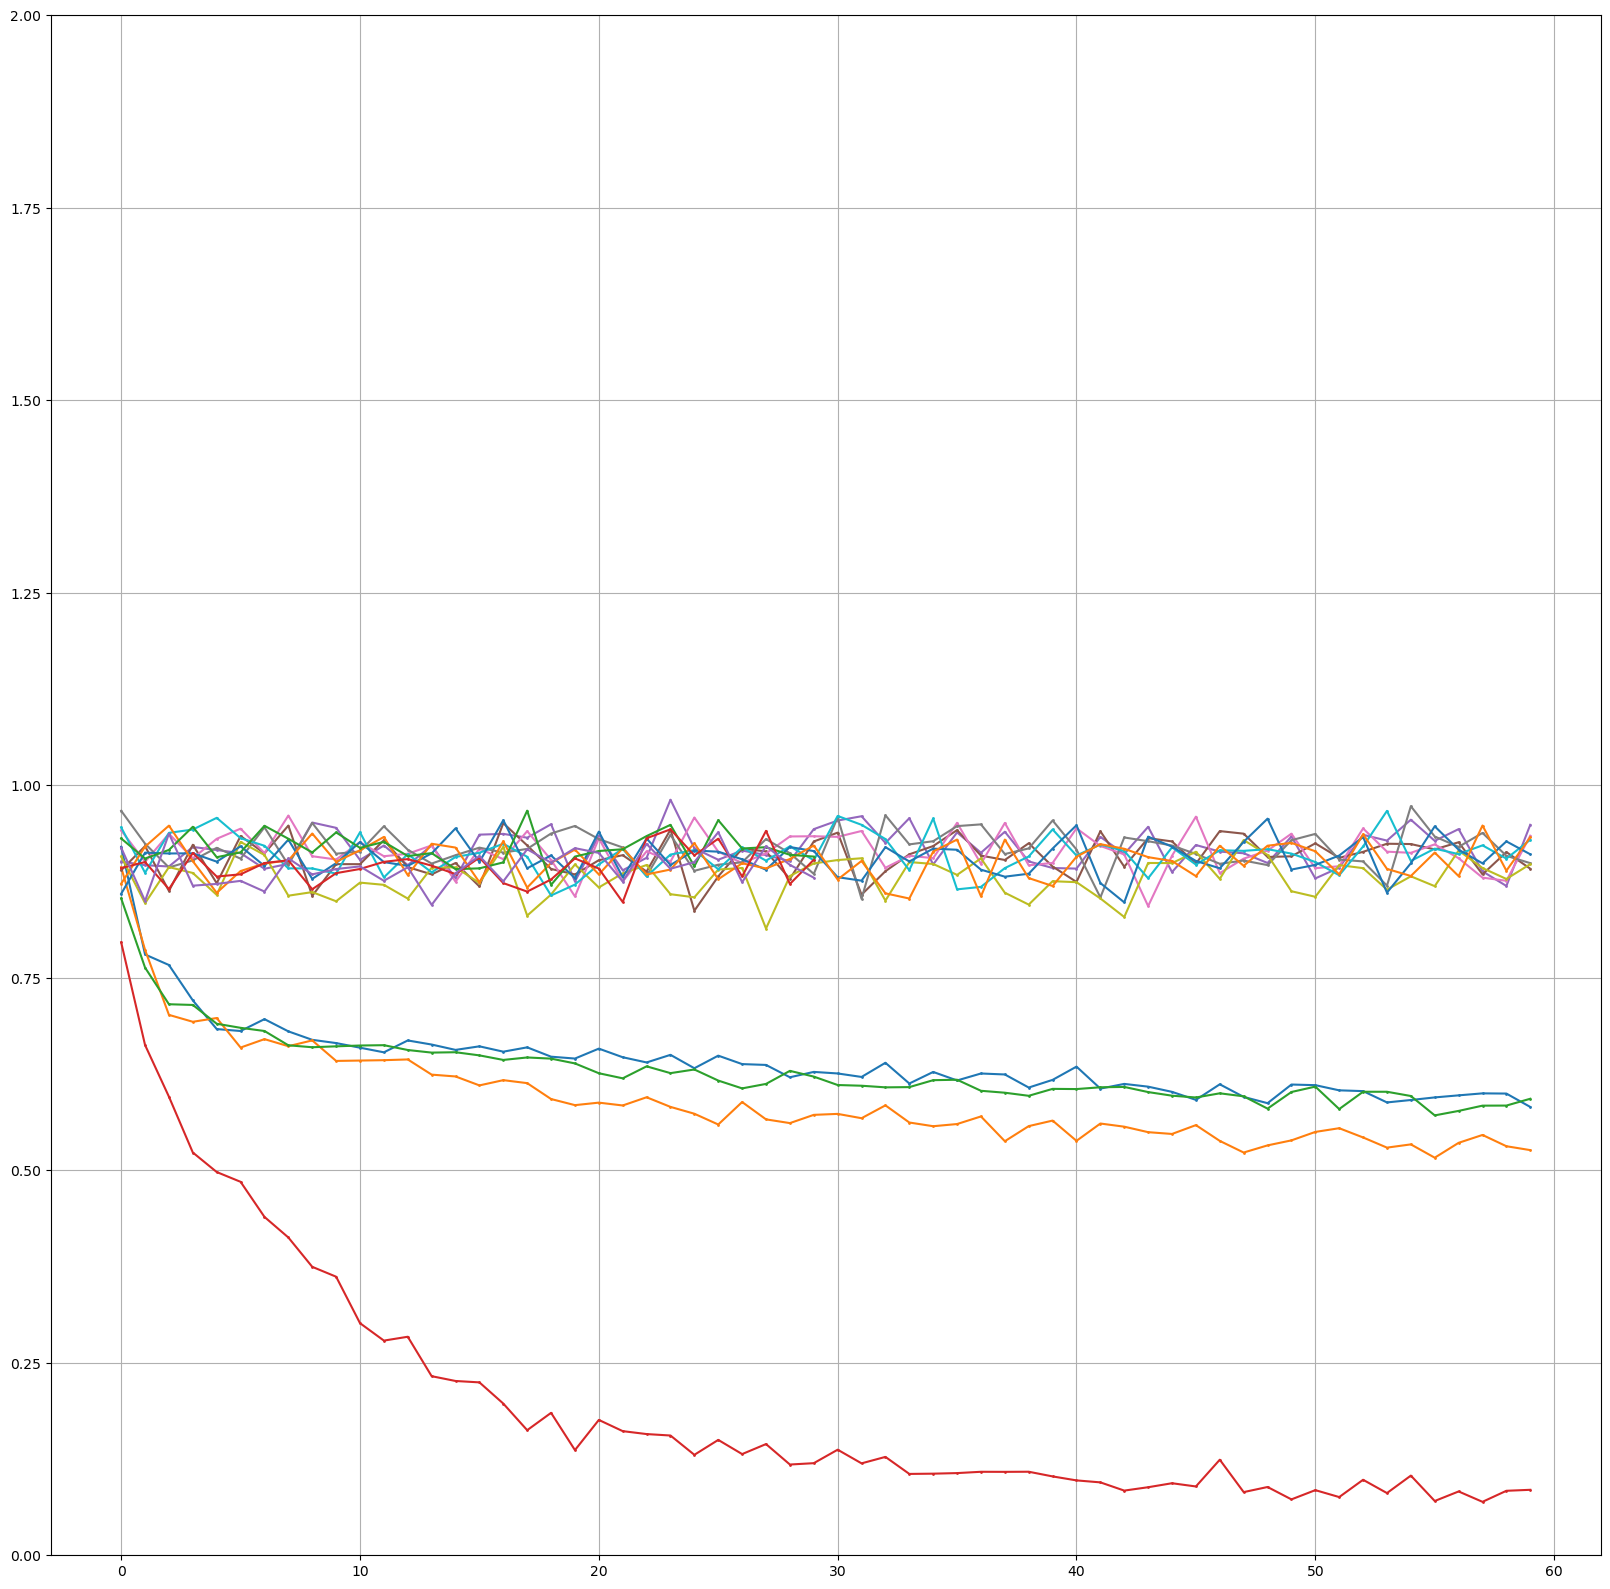

In [24]:
draw_loss_from_folder('loss/running/changing/')

In [ ]:
# eficient b3 yet the best
draw_loss_graphs([adrt, rt1, rt2, srt, amrt2, apdrt2, yrt2, srt3, rAccSGD])

In [ ]:
# Train the teacher network
t1, rt = train_teacher(teacher_student.teacher, feature_extractor, train_loader, device, 60)
loss_teacher.extend(t)
running_loss_teacher.extend(rt)

In [ ]:
# Train the student and augmenter


In [ ]:
# Train the binary classifier
loss_classifier.extend(train_binary_classifier(teacher_student.teacher, teacher_student.student, binary_classifier.binary_classifier, feature_extractor, train_loader, device, 16))

In [ ]:
testacc = test_binary_classifier(teacher_student.teacher, teacher_student.student, binary_classifier.binary_classifier, feature_extractor, test_loader, device)
add_log(f'Test dataset accuracy: {testacc}')

In [ ]:
testacc = test_teacher(teacher_student.teacher, feature_extractor, comb2_test_loader, device)
add_log(f'Test dataset accuracy: {testacc}')

In [ ]:
save_loss('loss_teacher_clip_norm_nosheluder.txt', loss_teacher)

In [ ]:

# for i in range(10):
#     # Train the student network
#     train_student(teacher_student.teacher, teacher_student.student, feature_extractor, augmenter, train_loader, device, 1, margin= 1.0)
#     save_checkpoint(teacher_student.teacher, filename='student_cpt', epoch=i)
    
#     # Traun the augmenter
#     train_augmenter(teacher_student.teacher, teacher_student.student, feature_extractor, augmenter, train_loader, device, 1)
#     save_checkpoint(teacher_student.teacher, filename='augmenter_cpt', epoch=i)
    

In [ ]:
mytest_image_paths, mytest_labels = load_image_paths_and_labels('C:/Users/Danila/VSU/vsu_common_rep/vsu_common_rep/2year/2term/project/image_classification/content/mytestset/')
mytest_dataset = RealFakeDataset(mytest_image_paths, mytest_labels, transform=transform)
mytest_loader = DataLoader(mytest_dataset, batch_size=64, shuffle=False)

In [ ]:
mytestacc = test_binary_classifier(teacher_student.teacher, teacher_student.student, binary_classifier.binary_classifier, feature_extractor, mytest_loader, device)
add_log(f'My test dataset accuracy: {mytestacc}')

In [ ]:
comb_test_image_paths, comb_test_labels = load_image_paths_and_labels('C:/Users/Danila/VSU/vsu_common_rep/vsu_common_rep/2year/2term/project/image_classification/content/combined/')
comb_test_dataset = RealFakeDataset(comb_test_image_paths, comb_test_labels, transform=transform)
comb_test_loader = DataLoader(comb_test_dataset, batch_size=64, shuffle=False)

In [ ]:
combtestacc = test_binary_classifier(teacher_student.teacher, teacher_student.student, binary_classifier.binary_classifier, feature_extractor, comb_test_loader, device)
add_log(f'Combined test dataset accuracy: {combtestacc}')

In [ ]:
comb2_test_image_paths, comb2_test_labels = load_image_paths_and_labels('C:/Users/Danila/VSU/vsu_common_rep/vsu_common_rep/2year/2term/project/image_classification/content/combined2/')
comb2_test_dataset = RealFakeDataset(comb2_test_image_paths, comb_test_labels, transform=transform)
comb2_test_loader = DataLoader(comb2_test_dataset, batch_size=64, shuffle=False)

In [ ]:
comb2testacc = test_binary_classifier(teacher_student.teacher, teacher_student.student, binary_classifier.binary_classifier, feature_extractor, comb2_test_loader, device)
add_log(f'Combined test dataset accuracy: {combtestacc}')

In [ ]:
print(len(comb_test_dataset))

In [ ]:
limage_paths, mytest_labels = load_image_paths_and_labels("D:progan_train/progan_train/")
lfull_dataset = RealFakeDataset(mytest_image_paths, mytest_labels, transform=transform)
ltrain_size = int(0.2 * len(lfull_dataset))
ltest_size = len(lfull_dataset) - ltrain_size
ltrain_dataset, ltest_dataset = torch.utils.data.random_split(lfull_dataset, [ltrain_size, ltest_size])
ltest_loader = DataLoader(ltest_dataset, batch_size=64, shuffle=False)

In [ ]:
ltestacc = test_binary_classifier(teacher_student.teacher, teacher_student.student, binary_classifier.binary_classifier, feature_extractor, ltest_loader, device)
add_log(f'Large test dataset accuracy: {ltestacc}')

In [ ]:
ltestaccteacher = test_teacher(teacher_student.teacher, feature_extractor, ltest_loader, device)
add_log(f'Large test dataset accuracy: {ltestacc}')

In [ ]:
save_checkpoint(teacher_student.teacher, filename='teacher_test_cpt', epoch=0)
save_checkpoint(teacher_student.student, filename='student_test_cpt', epoch=0)
save_checkpoint(augmenter.feature_augmenter, filename='augmenter_test_cpt', epoch=0)
save_checkpoint(binary_classifier.binary_classifier, filename='bin_classifier_test_cpt', epoch=0)

In [ ]:
load_checkpoint(teacher_student.student, 'models/student_cpt_epoch29.pth.tar')

In [ ]:
load_checkpoint(teacher_student.teacher, 'models/teacher_cpt_epoch5.pth.tar')

In [ ]:
load_checkpoint(augmenter.feature_augmenter, 'models/augmenter_cpt_epoch29.pth.tar')

In [ ]:
load_checkpoint(binary_classifier.binary_classifier, 'models/bin_classifier_cpt_epoch12.pth.tar')